# Data Description

The aim of this competition is to predict a patient’s severity of decline in lung function based on a CT scan of their lungs. Lung function is assessed based on output from a spirometer, which measures the forced vital capacity (FVC), i.e. the volume of air exhaled.

In the dataset, you are provided with a baseline chest CT scan and associated clinical information for a set of patients. A patient has an image acquired at time Week = 0 and has numerous follow up visits over the course of approximately 1-2 years, at which time their FVC is measured.

* In the training set, you are provided with an anonymized, baseline CT scan and the entire history of FVC measurements.
* In the test set, you are provided with a baseline CT scan and only the initial FVC measurement. You are asked to predict the final three FVC measurements for each patient, as well as a confidence value in your prediction. 

There are around 200 cases in the public & private test sets, combined. This is split roughly 15-85 between public-private.

Since this is real medical data, you will notice the relative timing of FVC measurements varies widely. The timing of the initial measurement relative to the CT scan and the duration to the forecasted time points may be different for each patient. This is considered part of the challenge of the competition. To avoid potential leakage in the timing of follow up visits, you are asked to predict every patient's FVC measurement for every possible week. Those weeks which are not in the final three visits are ignored in scoring.
## Files

This is a synchronous rerun code competition. The provided test set is a small representative set of files (copied from the training set) to demonstrate the format of the private test set. When you submit your notebook, Kaggle will rerun your code on the test set, which contains unseen images.

train.csv - the training set, contains full history of clinical information
test.csv - the test set, contains only the baseline measurement
train/ - contains the training patients' baseline CT scan in DICOM format
test/ - contains the test patients' baseline CT scan in DICOM format
sample_submission.csv - demonstrates the submission format *italicized text*

## Columns
train.csv and test.csv

* Patient- a unique Id for each patient (also the name of the patient's DICOM folder)
* Weeks- the relative number of weeks pre/post the baseline CT (may be negative)
* FVC - the recorded lung capacity in ml
* Percent- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
  * Age
  * Sex
  * SmokingStatus 

sample submission.csv

* Patient_Week - a unique Id formed by concatenating the Patient and Weeks columns (i.e. ABC_22 is a prediction for patient ABC at week 22)
* FVC - the predicted FVC in ml
* Confidence - a confidence value of your prediction (also has units of ml) 


# **EDA**
## On data containing Patient, Weeks, FVC, Percent,	Age, Sex and	SmokingStatus

In [14]:
pip install pydicom

In [ ]:
import matplotlib.pyplot as plt # plotting
from matplotlib.pyplot import figure
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # Decorate an iterable object, returning an iterator which acts exactly like the original iterable, 
                      # but prints a dynamically updating progressbar every time a value is requested
import seaborn as sns #Seaborn is a library for making statistical graphics in Python
from pandas.plotting import table 
import time # provides various time-related functions
from datetime import timedelta #timedelta:- A duration expressing the difference between two date, time, or datetime.
from google.colab import drive # Downloading Datasets into Google Drive via Google Colab
import os.path

from pydicom import dcmread
from pydicom.data import get_testdata_file

In [ ]:
#Functions to save objects for future usage and repossess
#https://stackoverflow.com/questions/1253528/is-there-an-easy-way-to-pickle-a-python-function-or-otherwise-serialize-its-cod
import pickle
def transmit(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)
def receive(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [ ]:
drive.mount('/content/drive') # for mounting Google Drive files 

Mounted at /content/drive


In [ ]:
## List out the available directories in the first Drive path
print('Available dataset partitions: ', os.listdir('drive/My Drive/Colab Notebooks'))

Available dataset partitions:  ['sample_submission.csv', 'train.csv', 'test.csv', 'Pulmonary_Fibrosis_EDA_FVC.ipynb', 'test', 'train1', 'Untitled0.ipynb', 'Untitled1.ipynb', 'Untitled.ipynb', 'Pulmonary_Fibrosis_EDA_FVC_dicom.ipynb', 'Untitled', 'Pulmonary_Fibrosis_EDA_Dicom_FVC.ipynb']


In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!sudo mkdir /content/drive1
!google-drive-ocamlfuse /content/drive1

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 146442 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
## List out the available directories in the second Drive1 path
print('Available dataset partitions: ', os.listdir('drive1/Colab Notebooks'))

Available dataset partitions:  ['Untitled0.ipynb', 'train2']


In [ ]:
! dir

adc.json  drive  drive1  sample_data


In [29]:
print('Available dataset partitions: ', os.listdir('drive1/Colab Notebooks/train2'))

Available dataset partitions:  ['ID00072637202198161894406', 'ID00132637202222178761324', 'ID00011637202177653955184', 'ID00007637202177411956430', 'ID00010637202177584971671', 'ID00014637202177757139317', 'ID00130637202220059448013', 'ID00133637202223847701934', 'ID00068637202190879923934', 'ID00123637202217151272140', 'ID00082637202201836229724', 'ID00110637202210673668310', 'ID00073637202198167792918', 'ID00124637202217596410344', 'ID00129637202219868188000', 'ID00138637202231603868088', 'ID00078637202199415319443', 'ID00125637202218590429387', 'ID00030637202181211009029', 'ID00131637202220424084844', 'ID00038637202182690843176', 'ID00042637202184406822975', 'ID00140637202231728595149', 'ID00067637202189903532242', 'ID00122637202216437668965', 'ID00094637202205333947361', 'ID00060637202187965290703', 'ID00136637202224951350618', 'ID00012637202177665765362', 'ID00104637202208063407045', 'ID00086637202203494931510', 'ID00061637202188184085559', 'ID00169637202238024117706', 'ID00119637

In [ ]:
for x in dcm_9637202177434476278:
  CTScanImage('ID00167637202237397919352',x)

In [ ]:
df_pul_fib_train = pd.read_csv('drive/My Drive/Colab Notebooks/train.csv')
df_pul_fib_test = pd.read_csv('drive/My Drive/Colab Notebooks/test.csv')

In [ ]:
df_pul_fib_train[0:10]

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
5  ID00007637202177411956430     17  2101  52.868646   79  Male     Ex-smoker
6  ID00007637202177411956430     29  2000  50.327126   79  Male     Ex-smoker
7  ID00007637202177411956430     41  2064  51.937594   79  Male     Ex-smoker
8  ID00007637202177411956430     57  2057  51.761449   79  Male     Ex-smoker
9  ID00009637202177434476278      8  3660  85.282878   69  Male     Ex-smoker

In [ ]:
df_pul_fib_train.Patient.describe()

count                          1549
unique                          176
top       ID00343637202287577133798
freq                             10
Name: Patient, dtype: object

In [ ]:
# Below code will display  number of repeated row for each unique row (Patient ID)
# https://stackoverflow.com/a/35584675

df_pul_fib_train.groupby(df_pul_fib_train.Patient.tolist(),as_index=False).size()

index  size
0    ID00007637202177411956430     9
1    ID00009637202177434476278     9
2    ID00010637202177584971671     9
3    ID00011637202177653955184     9
4    ID00012637202177665765362     9
..                         ...   ...
171  ID00419637202311204720264     9
172  ID00421637202311550012437    10
173  ID00422637202311677017371     8
174  ID00423637202312137826377     9
175  ID00426637202313170790466     9

[176 rows x 2 columns]

In [ ]:
df_pul_fib_train.loc[(df_pul_fib_train['Patient']=='ID00007637202177411956430')]

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
5  ID00007637202177411956430     17  2101  52.868646   79  Male     Ex-smoker
6  ID00007637202177411956430     29  2000  50.327126   79  Male     Ex-smoker
7  ID00007637202177411956430     41  2064  51.937594   79  Male     Ex-smoker
8  ID00007637202177411956430     57  2057  51.761449   79  Male     Ex-smoker

In [ ]:
df_train_uni = df_pul_fib_train.drop_duplicates(subset ="Patient")
df_train_uni

Patient  Weeks   FVC  ...  Age   Sex SmokingStatus
0     ID00007637202177411956430     -4  2315  ...   79  Male     Ex-smoker
9     ID00009637202177434476278      8  3660  ...   69  Male     Ex-smoker
18    ID00010637202177584971671      0  3523  ...   60  Male     Ex-smoker
27    ID00011637202177653955184      6  3326  ...   72  Male     Ex-smoker
36    ID00012637202177665765362     33  3418  ...   65  Male  Never smoked
...                         ...    ...   ...  ...  ...   ...           ...
1504  ID00419637202311204720264      6  3020  ...   73  Male     Ex-smoker
1513  ID00421637202311550012437     15  2739  ...   68  Male     Ex-smoker
1523  ID00422637202311677017371      6  1930  ...   73  Male     Ex-smoker
1531  ID00423637202312137826377     17  3294  ...   72  Male     Ex-smoker
1540  ID00426637202313170790466      0  2925  ...   73  Male  Never smoked

[176 rows x 7 columns]

In [ ]:
df_train_uni.reset_index(inplace = True, drop = True) 
df_train_uni

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0    ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1    ID00009637202177434476278      8  3660  85.282878   69  Male     Ex-smoker
2    ID00010637202177584971671      0  3523  94.724672   60  Male     Ex-smoker
3    ID00011637202177653955184      6  3326  85.987590   72  Male     Ex-smoker
4    ID00012637202177665765362     33  3418  93.726006   65  Male  Never smoked
..                         ...    ...   ...        ...  ...   ...           ...
171  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker
172  ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker
173  ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker
174  ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker
175  ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked

[176 rows x 7 columns]

In [ ]:
df_train_uni.loc[0]

Patient          ID00007637202177411956430
Weeks                                   -4
FVC                                   2315
Percent                            58.2536
Age                                     79
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 0, dtype: object

In [ ]:
def patient_id (row_no):
  id = df_pul_fib_train.loc[(df_pul_fib_train['Patient']==df_train_uni.loc[row_no]['Patient'])]
  return id

In [ ]:
patient_id (0)

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
5  ID00007637202177411956430     17  2101  52.868646   79  Male     Ex-smoker
6  ID00007637202177411956430     29  2000  50.327126   79  Male     Ex-smoker
7  ID00007637202177411956430     41  2064  51.937594   79  Male     Ex-smoker
8  ID00007637202177411956430     57  2057  51.761449   79  Male     Ex-smoker

In [ ]:
def plot_patient_id(row_no):
# https://stackoverflow.com/a/20132200
  x = patient_id(row_no)['Weeks']
  y = patient_id(row_no)['FVC']
  m, b = np.polyfit(x, y, 1)
  plt.plot(x, y,'-o')
  plt.plot(x, m*x + b)
  plt.show()
  detail = df_train_uni.loc[row_no][['Patient', 'Age', 'Sex','SmokingStatus']]
  return print(detail)

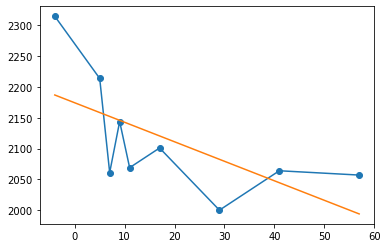

Patient          ID00007637202177411956430
Age                                     79
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 0, dtype: object


In [ ]:
plot_patient_id(0)

FVC vs Weeks Plot No. 0
------------------------


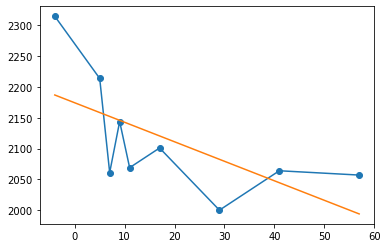

Patient          ID00007637202177411956430
Age                                     79
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 0, dtype: object
**********************************************


FVC vs Weeks Plot No. 1
------------------------


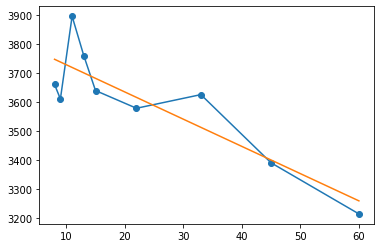

Patient          ID00009637202177434476278
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 1, dtype: object
**********************************************


FVC vs Weeks Plot No. 2
------------------------


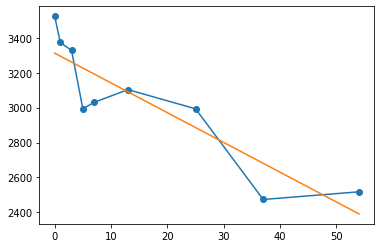

Patient          ID00010637202177584971671
Age                                     60
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 2, dtype: object
**********************************************


FVC vs Weeks Plot No. 3
------------------------


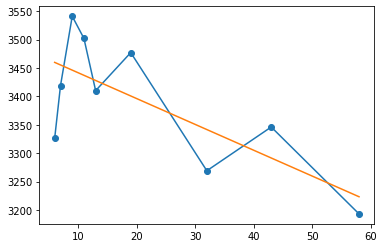

Patient          ID00011637202177653955184
Age                                     72
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 3, dtype: object
**********************************************


FVC vs Weeks Plot No. 4
------------------------


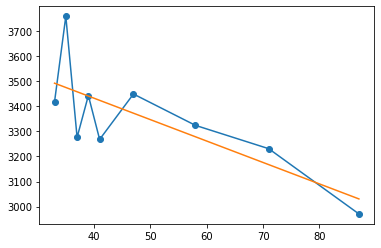

Patient          ID00012637202177665765362
Age                                     65
Sex                                   Male
SmokingStatus                 Never smoked
Name: 4, dtype: object
**********************************************


FVC vs Weeks Plot No. 5
------------------------


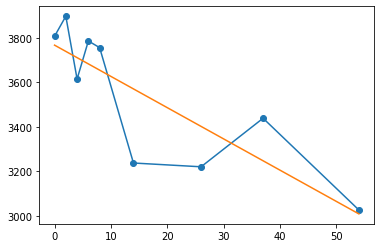

Patient          ID00014637202177757139317
Age                                     56
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 5, dtype: object
**********************************************


FVC vs Weeks Plot No. 6
------------------------


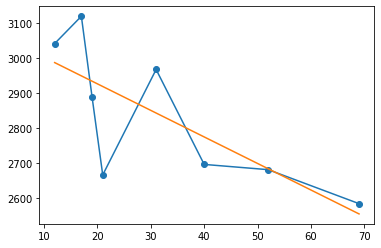

Patient          ID00015637202177877247924
Age                                     71
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 6, dtype: object
**********************************************


FVC vs Weeks Plot No. 7
------------------------


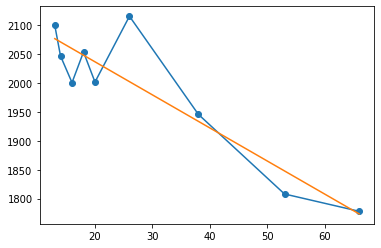

Patient          ID00019637202178323708467
Age                                     83
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 7, dtype: object
**********************************************


FVC vs Weeks Plot No. 8
------------------------


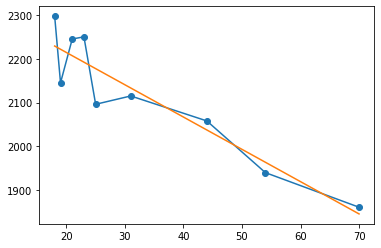

Patient          ID00020637202178344345685
Age                                     66
Sex                                 Female
SmokingStatus                 Never smoked
Name: 8, dtype: object
**********************************************


FVC vs Weeks Plot No. 9
------------------------


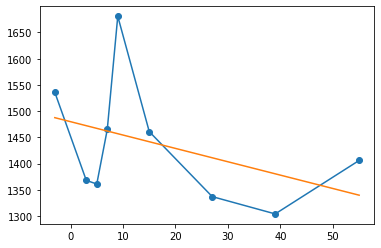

Patient          ID00023637202179104603099
Age                                     71
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 9, dtype: object
**********************************************


FVC vs Weeks Plot No. 10
------------------------


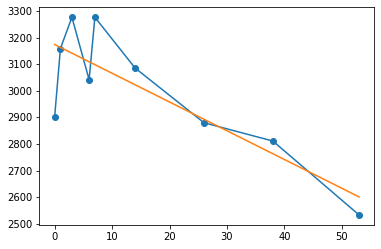

Patient          ID00025637202179541264076
Age                                     65
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 10, dtype: object
**********************************************


FVC vs Weeks Plot No. 11
------------------------


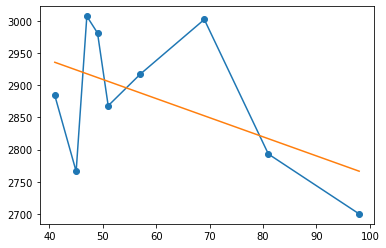

Patient          ID00026637202179561894768
Age                                     57
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 11, dtype: object
**********************************************


FVC vs Weeks Plot No. 12
------------------------


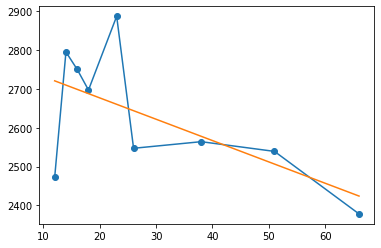

Patient          ID00027637202179689871102
Age                                     73
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 12, dtype: object
**********************************************


FVC vs Weeks Plot No. 13
------------------------


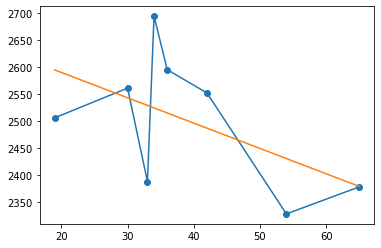

Patient          ID00030637202181211009029
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 13, dtype: object
**********************************************


FVC vs Weeks Plot No. 14
------------------------


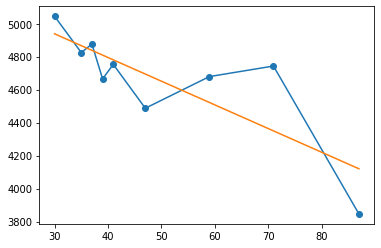

Patient          ID00032637202181710233084
Age                                     63
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 14, dtype: object
**********************************************


FVC vs Weeks Plot No. 15
------------------------


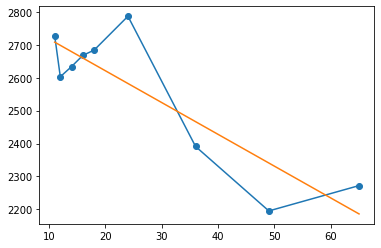

Patient          ID00035637202182204917484
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 15, dtype: object
**********************************************


FVC vs Weeks Plot No. 16
------------------------


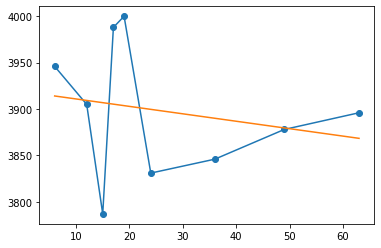

Patient          ID00038637202182690843176
Age                                     71
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 16, dtype: object
**********************************************


FVC vs Weeks Plot No. 17
------------------------


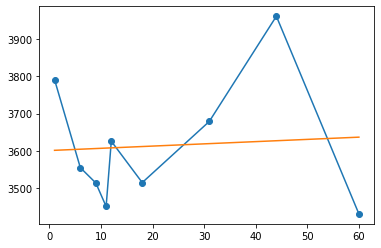

Patient          ID00042637202184406822975
Age                                     58
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 17, dtype: object
**********************************************


FVC vs Weeks Plot No. 18
------------------------


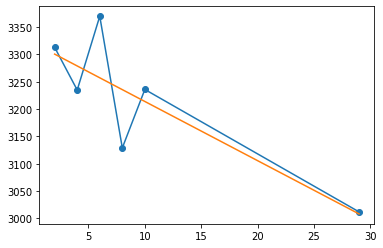

Patient          ID00047637202184938901501
Age                                     68
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 18, dtype: object
**********************************************


FVC vs Weeks Plot No. 19
------------------------


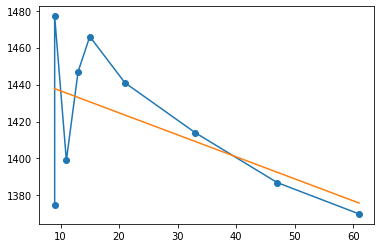

Patient          ID00048637202185016727717
Age                                     70
Sex                                 Female
SmokingStatus                 Never smoked
Name: 19, dtype: object
**********************************************


FVC vs Weeks Plot No. 20
------------------------


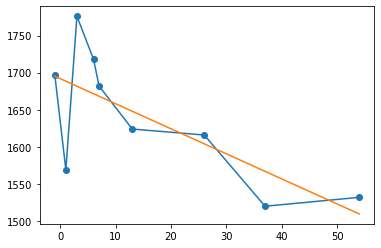

Patient          ID00051637202185848464638
Age                                     73
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 20, dtype: object
**********************************************


FVC vs Weeks Plot No. 21
------------------------


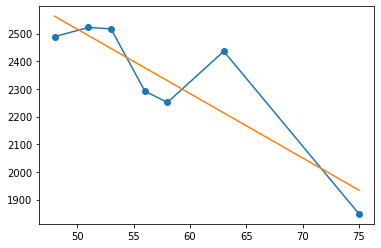

Patient          ID00052637202186188008618
Age                                     54
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 21, dtype: object
**********************************************


FVC vs Weeks Plot No. 22
------------------------


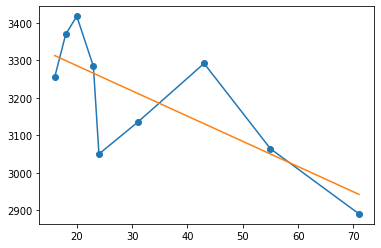

Patient          ID00060637202187965290703
Age                                     63
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 22, dtype: object
**********************************************


FVC vs Weeks Plot No. 23
------------------------


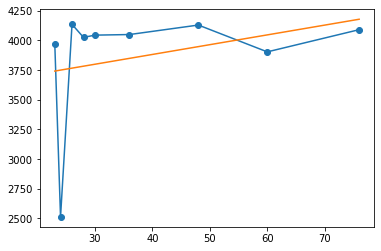

Patient          ID00061637202188184085559
Age                                     68
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 23, dtype: object
**********************************************


FVC vs Weeks Plot No. 24
------------------------


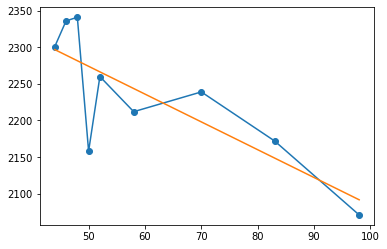

Patient          ID00062637202188654068490
Age                                     74
Sex                                   Male
SmokingStatus                 Never smoked
Name: 24, dtype: object
**********************************************


FVC vs Weeks Plot No. 25
------------------------


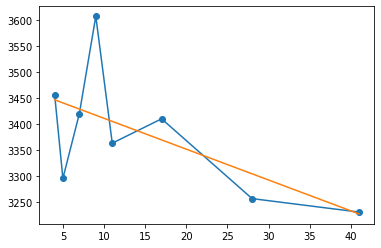

Patient          ID00067637202189903532242
Age                                     64
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 25, dtype: object
**********************************************


FVC vs Weeks Plot No. 26
------------------------


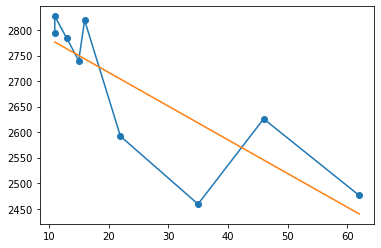

Patient          ID00068637202190879923934
Age                                     73
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 26, dtype: object
**********************************************


FVC vs Weeks Plot No. 27
------------------------


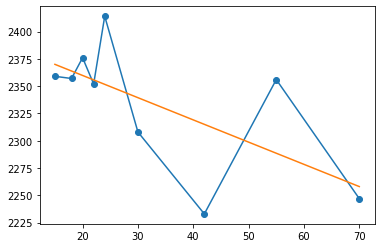

Patient          ID00072637202198161894406
Age                                     71
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 27, dtype: object
**********************************************


FVC vs Weeks Plot No. 28
------------------------


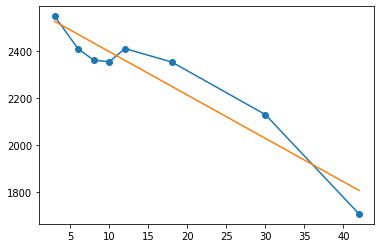

Patient          ID00073637202198167792918
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 28, dtype: object
**********************************************


FVC vs Weeks Plot No. 29
------------------------


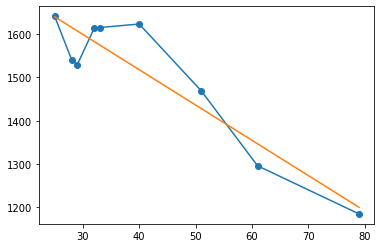

Patient          ID00075637202198610425520
Age                                     52
Sex                                 Female
SmokingStatus                 Never smoked
Name: 29, dtype: object
**********************************************


FVC vs Weeks Plot No. 30
------------------------


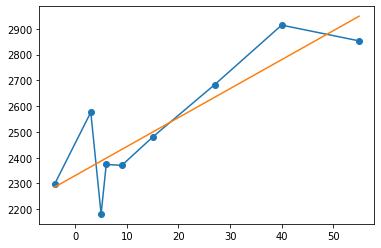

Patient          ID00076637202199015035026
Age                                     51
Sex                                   Male
SmokingStatus                 Never smoked
Name: 30, dtype: object
**********************************************


FVC vs Weeks Plot No. 31
------------------------


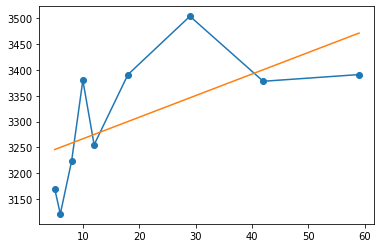

Patient          ID00077637202199102000916
Age                                     70
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 31, dtype: object
**********************************************


FVC vs Weeks Plot No. 32
------------------------


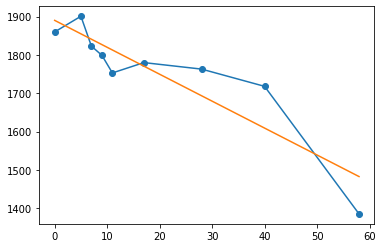

Patient          ID00078637202199415319443
Age                                     55
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 32, dtype: object
**********************************************


FVC vs Weeks Plot No. 33
------------------------


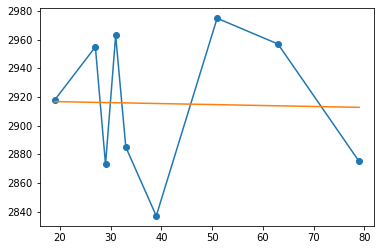

Patient          ID00082637202201836229724
Age                                     49
Sex                                 Female
SmokingStatus             Currently smokes
Name: 33, dtype: object
**********************************************


FVC vs Weeks Plot No. 34
------------------------


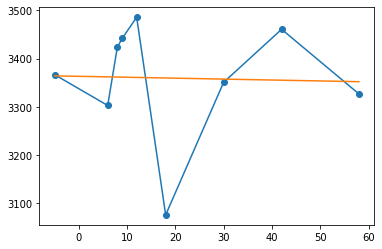

Patient          ID00086637202203494931510
Age                                     65
Sex                                 Female
SmokingStatus                 Never smoked
Name: 34, dtype: object
**********************************************


FVC vs Weeks Plot No. 35
------------------------


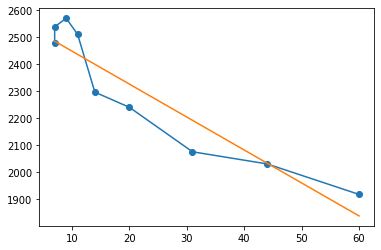

Patient          ID00089637202204675567570
Age                                     63
Sex                                   Male
SmokingStatus                 Never smoked
Name: 35, dtype: object
**********************************************


FVC vs Weeks Plot No. 36
------------------------


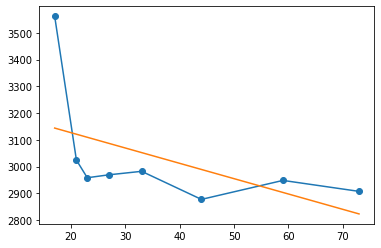

Patient          ID00090637202204766623410
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 36, dtype: object
**********************************************


FVC vs Weeks Plot No. 37
------------------------


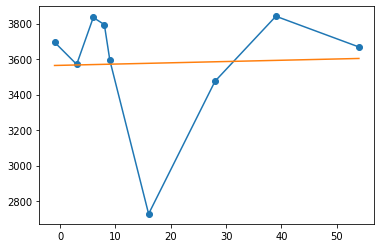

Patient          ID00093637202205278167493
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 37, dtype: object
**********************************************


FVC vs Weeks Plot No. 38
------------------------


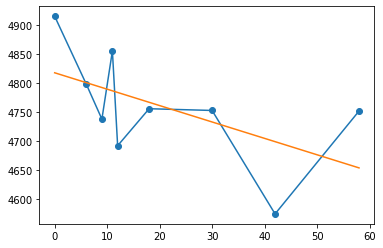

Patient          ID00094637202205333947361
Age                                     64
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 38, dtype: object
**********************************************


FVC vs Weeks Plot No. 39
------------------------


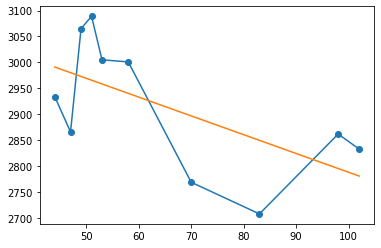

Patient          ID00099637202206203080121
Age                                     68
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 39, dtype: object
**********************************************


FVC vs Weeks Plot No. 40
------------------------


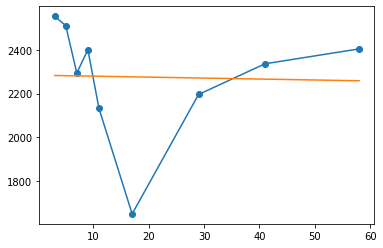

Patient          ID00102637202206574119190
Age                                     60
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 40, dtype: object
**********************************************


FVC vs Weeks Plot No. 41
------------------------


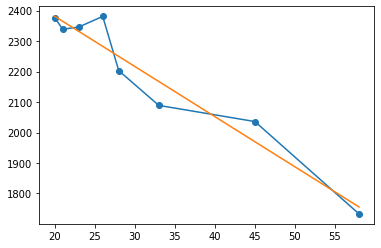

Patient          ID00104637202208063407045
Age                                     74
Sex                                   Male
SmokingStatus                 Never smoked
Name: 41, dtype: object
**********************************************


FVC vs Weeks Plot No. 42
------------------------


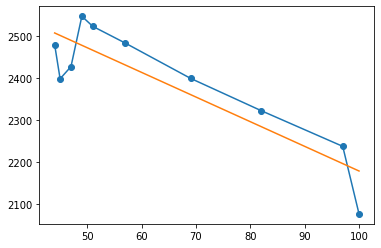

Patient          ID00105637202208831864134
Age                                     64
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 42, dtype: object
**********************************************


FVC vs Weeks Plot No. 43
------------------------


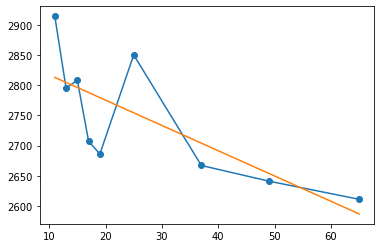

Patient          ID00108637202209619669361
Age                                     73
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 43, dtype: object
**********************************************


FVC vs Weeks Plot No. 44
------------------------


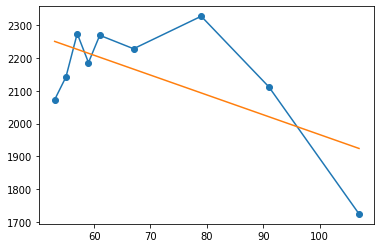

Patient          ID00109637202210454292264
Age                                     73
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 44, dtype: object
**********************************************


FVC vs Weeks Plot No. 45
------------------------


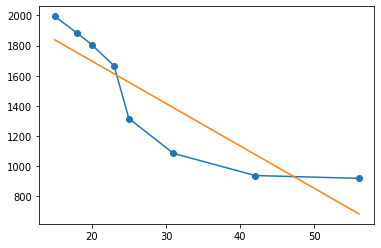

Patient          ID00110637202210673668310
Age                                     74
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 45, dtype: object
**********************************************


FVC vs Weeks Plot No. 46
------------------------


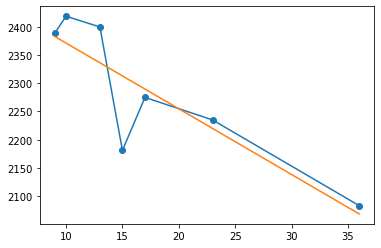

Patient          ID00111637202210956877205
Age                                     72
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 46, dtype: object
**********************************************


FVC vs Weeks Plot No. 47
------------------------


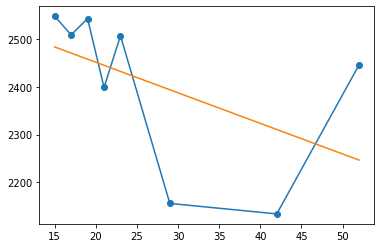

Patient          ID00115637202211874187958
Age                                     77
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 47, dtype: object
**********************************************


FVC vs Weeks Plot No. 48
------------------------


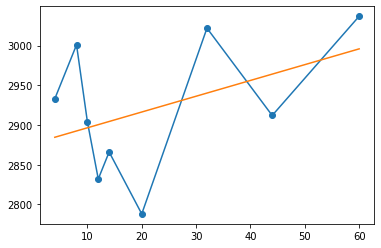

Patient          ID00117637202212360228007
Age                                     68
Sex                                   Male
SmokingStatus             Currently smokes
Name: 48, dtype: object
**********************************************


FVC vs Weeks Plot No. 49
------------------------


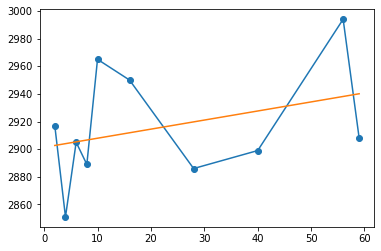

Patient          ID00119637202215426335765
Age                                     57
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 49, dtype: object
**********************************************


FVC vs Weeks Plot No. 50
------------------------


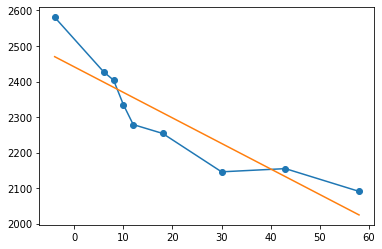

Patient          ID00122637202216437668965
Age                                     58
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 50, dtype: object
**********************************************


FVC vs Weeks Plot No. 51
------------------------


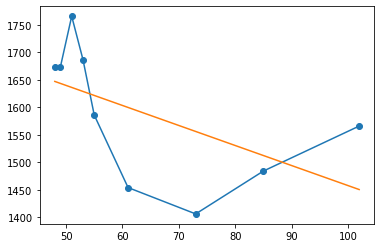

Patient          ID00123637202217151272140
Age                                     69
Sex                                 Female
SmokingStatus                 Never smoked
Name: 51, dtype: object
**********************************************


FVC vs Weeks Plot No. 52
------------------------


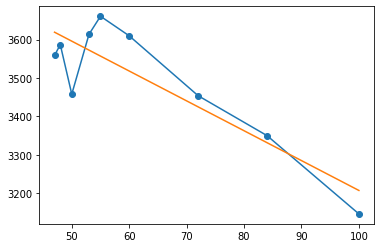

Patient          ID00124637202217596410344
Age                                     60
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 52, dtype: object
**********************************************


FVC vs Weeks Plot No. 53
------------------------


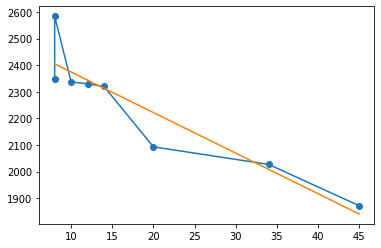

Patient          ID00125637202218590429387
Age                                     65
Sex                                   Male
SmokingStatus                 Never smoked
Name: 53, dtype: object
**********************************************


FVC vs Weeks Plot No. 54
------------------------


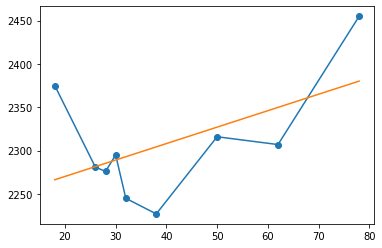

Patient          ID00126637202218610655908
Age                                     78
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 54, dtype: object
**********************************************


FVC vs Weeks Plot No. 55
------------------------


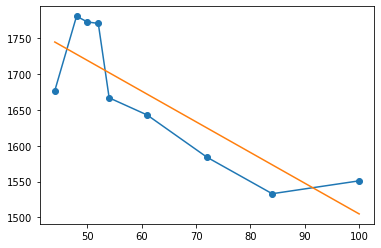

Patient          ID00127637202219096738943
Age                                     55
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 55, dtype: object
**********************************************


FVC vs Weeks Plot No. 56
------------------------


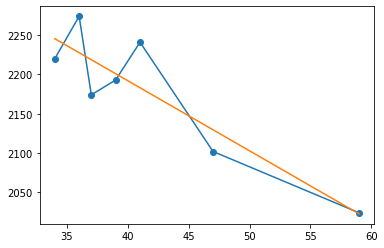

Patient          ID00128637202219474716089
Age                                     87
Sex                                 Female
SmokingStatus                 Never smoked
Name: 56, dtype: object
**********************************************


FVC vs Weeks Plot No. 57
------------------------


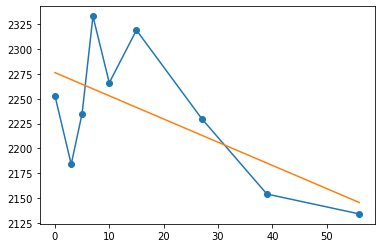

Patient          ID00129637202219868188000
Age                                     71
Sex                                   Male
SmokingStatus                 Never smoked
Name: 57, dtype: object
**********************************************


FVC vs Weeks Plot No. 58
------------------------


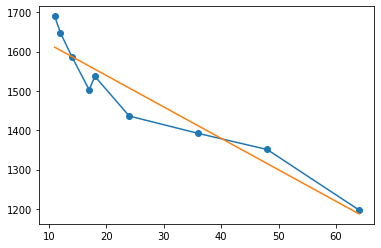

Patient          ID00130637202220059448013
Age                                     65
Sex                                 Female
SmokingStatus                 Never smoked
Name: 58, dtype: object
**********************************************


FVC vs Weeks Plot No. 59
------------------------


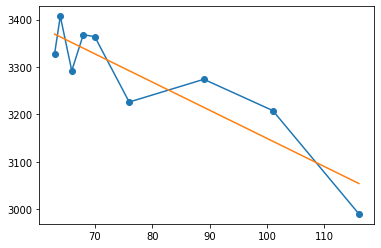

Patient          ID00131637202220424084844
Age                                     61
Sex                                   Male
SmokingStatus                 Never smoked
Name: 59, dtype: object
**********************************************


FVC vs Weeks Plot No. 60
------------------------


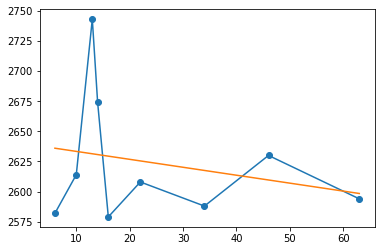

Patient          ID00132637202222178761324
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 60, dtype: object
**********************************************


FVC vs Weeks Plot No. 61
------------------------


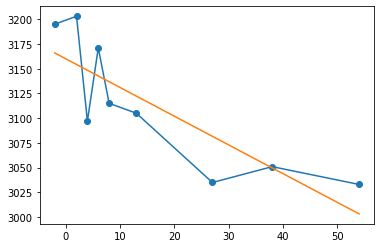

Patient          ID00133637202223847701934
Age                                     83
Sex                                   Male
SmokingStatus                 Never smoked
Name: 61, dtype: object
**********************************************


FVC vs Weeks Plot No. 62
------------------------


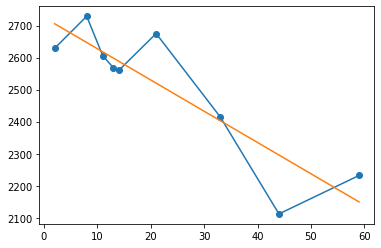

Patient          ID00134637202223873059688
Age                                     67
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 62, dtype: object
**********************************************


FVC vs Weeks Plot No. 63
------------------------


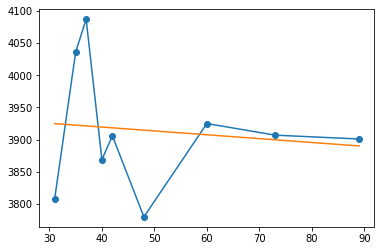

Patient          ID00135637202224630271439
Age                                     65
Sex                                   Male
SmokingStatus                 Never smoked
Name: 63, dtype: object
**********************************************


FVC vs Weeks Plot No. 64
------------------------


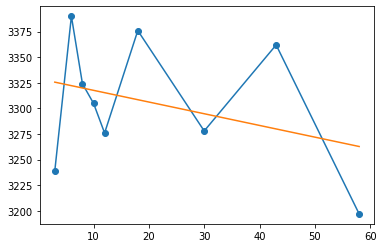

Patient          ID00136637202224951350618
Age                                     64
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 64, dtype: object
**********************************************


FVC vs Weeks Plot No. 65
------------------------


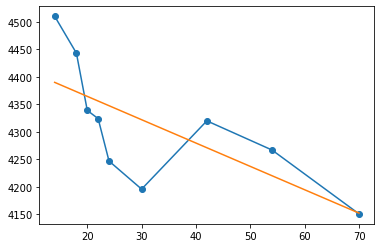

Patient          ID00138637202231603868088
Age                                     66
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 65, dtype: object
**********************************************


FVC vs Weeks Plot No. 66
------------------------


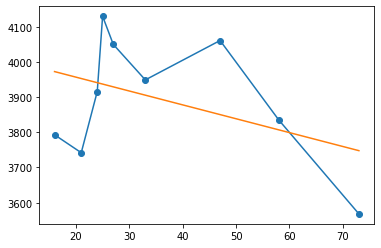

Patient          ID00139637202231703564336
Age                                     76
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 66, dtype: object
**********************************************


FVC vs Weeks Plot No. 67
------------------------


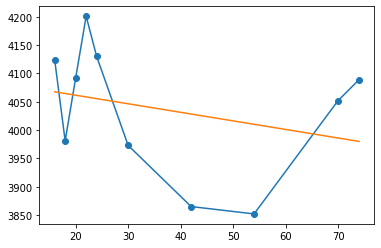

Patient          ID00140637202231728595149
Age                                     58
Sex                                   Male
SmokingStatus             Currently smokes
Name: 67, dtype: object
**********************************************


FVC vs Weeks Plot No. 68
------------------------


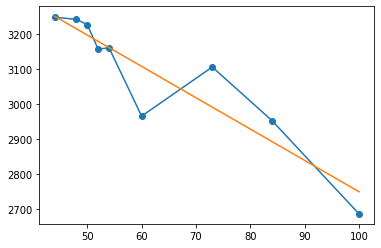

Patient          ID00149637202232704462834
Age                                     66
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 68, dtype: object
**********************************************


FVC vs Weeks Plot No. 69
------------------------


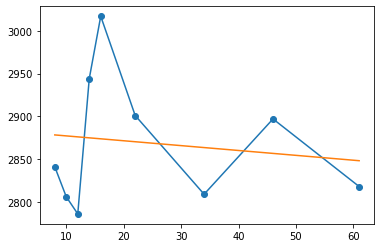

Patient          ID00161637202235731948764
Age                                     63
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 69, dtype: object
**********************************************


FVC vs Weeks Plot No. 70
------------------------


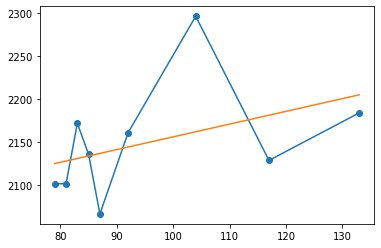

Patient          ID00165637202237320314458
Age                                     54
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 70, dtype: object
**********************************************


FVC vs Weeks Plot No. 71
------------------------


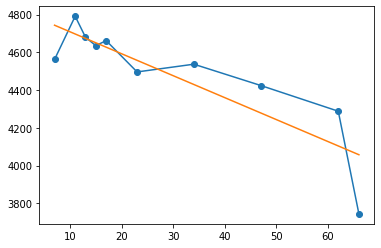

Patient          ID00167637202237397919352
Age                                     58
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 71, dtype: object
**********************************************


FVC vs Weeks Plot No. 72
------------------------


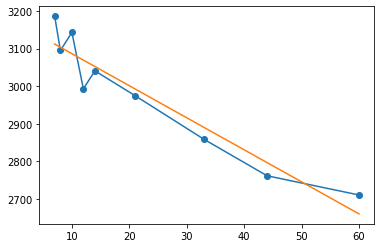

Patient          ID00168637202237852027833
Age                                     62
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 72, dtype: object
**********************************************


FVC vs Weeks Plot No. 73
------------------------


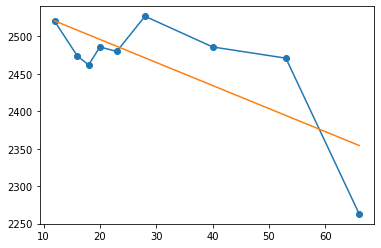

Patient          ID00169637202238024117706
Age                                     66
Sex                                 Female
SmokingStatus                 Never smoked
Name: 73, dtype: object
**********************************************


FVC vs Weeks Plot No. 74
------------------------


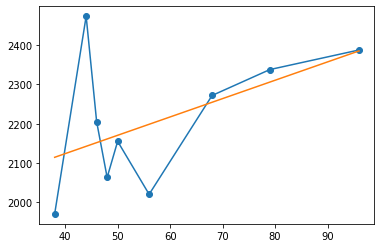

Patient          ID00170637202238079193844
Age                                     79
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 74, dtype: object
**********************************************


FVC vs Weeks Plot No. 75
------------------------


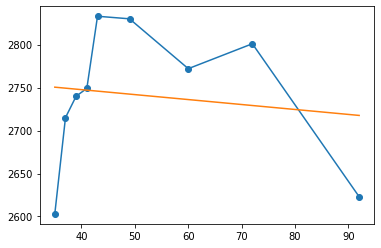

Patient          ID00172637202238316925179
Age                                     73
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 75, dtype: object
**********************************************


FVC vs Weeks Plot No. 76
------------------------


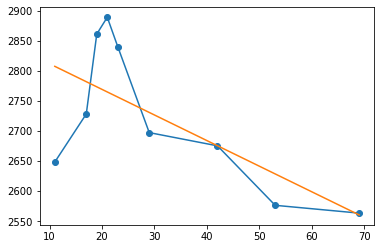

Patient          ID00173637202238329754031
Age                                     73
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 76, dtype: object
**********************************************


FVC vs Weeks Plot No. 77
------------------------


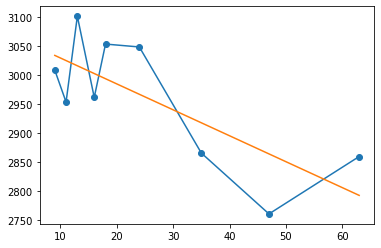

Patient          ID00180637202240177410333
Age                                     68
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 77, dtype: object
**********************************************


FVC vs Weeks Plot No. 78
------------------------


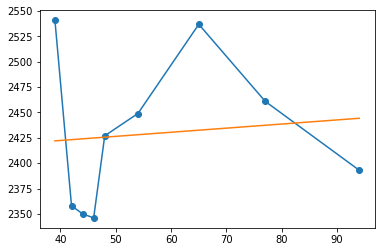

Patient          ID00183637202241995351650
Age                                     71
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 78, dtype: object
**********************************************


FVC vs Weeks Plot No. 79
------------------------


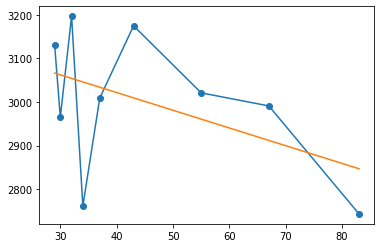

Patient          ID00184637202242062969203
Age                                     52
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 79, dtype: object
**********************************************


FVC vs Weeks Plot No. 80
------------------------


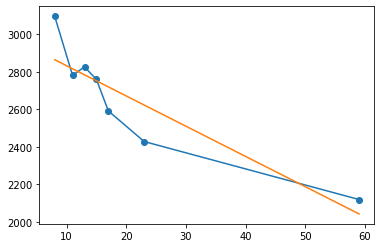

Patient          ID00186637202242472088675
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 80, dtype: object
**********************************************


FVC vs Weeks Plot No. 81
------------------------


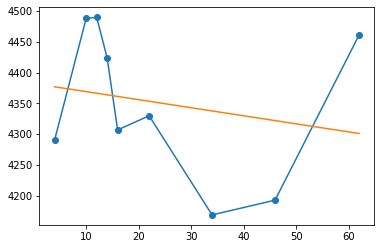

Patient          ID00190637202244450116191
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 81, dtype: object
**********************************************


FVC vs Weeks Plot No. 82
------------------------


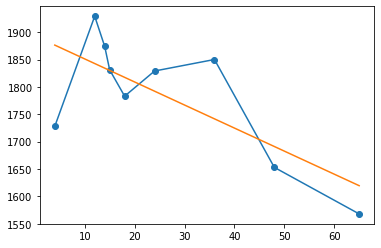

Patient          ID00192637202245493238298
Age                                     56
Sex                                 Female
SmokingStatus                 Never smoked
Name: 82, dtype: object
**********************************************


FVC vs Weeks Plot No. 83
------------------------


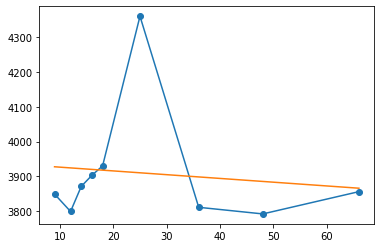

Patient          ID00196637202246668775836
Age                                     65
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 83, dtype: object
**********************************************


FVC vs Weeks Plot No. 84
------------------------


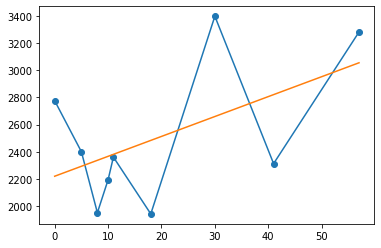

Patient          ID00197637202246865691526
Age                                     65
Sex                                   Male
SmokingStatus             Currently smokes
Name: 84, dtype: object
**********************************************


FVC vs Weeks Plot No. 85
------------------------


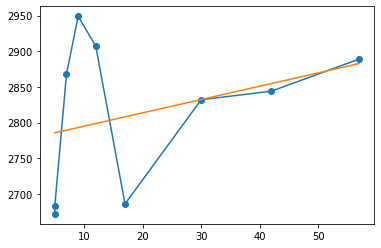

Patient          ID00199637202248141386743
Age                                     62
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 85, dtype: object
**********************************************


FVC vs Weeks Plot No. 86
------------------------


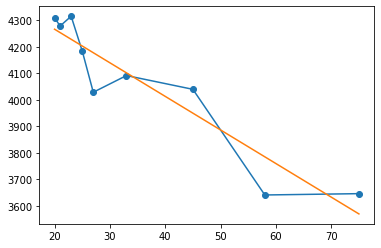

Patient          ID00202637202249376026949
Age                                     64
Sex                                   Male
SmokingStatus                 Never smoked
Name: 86, dtype: object
**********************************************


FVC vs Weeks Plot No. 87
------------------------


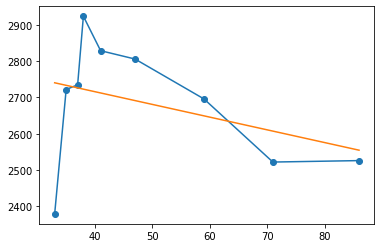

Patient          ID00207637202252526380974
Age                                     67
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 87, dtype: object
**********************************************


FVC vs Weeks Plot No. 88
------------------------


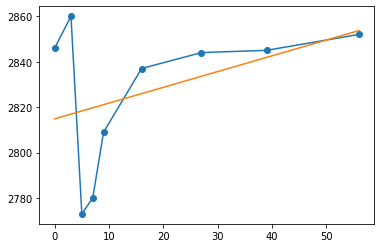

Patient          ID00210637202257228694086
Age                                     76
Sex                                   Male
SmokingStatus             Currently smokes
Name: 88, dtype: object
**********************************************


FVC vs Weeks Plot No. 89
------------------------


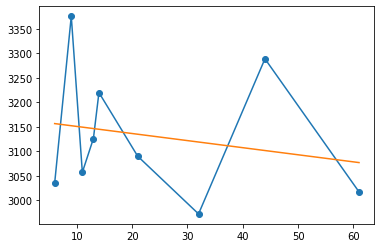

Patient          ID00213637202257692916109
Age                                     70
Sex                                   Male
SmokingStatus             Currently smokes
Name: 89, dtype: object
**********************************************


FVC vs Weeks Plot No. 90
------------------------


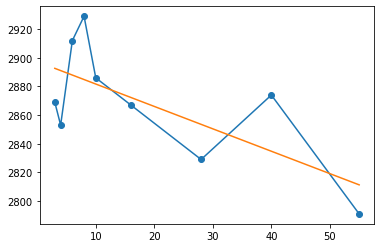

Patient          ID00214637202257820847190
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 90, dtype: object
**********************************************


FVC vs Weeks Plot No. 91
------------------------


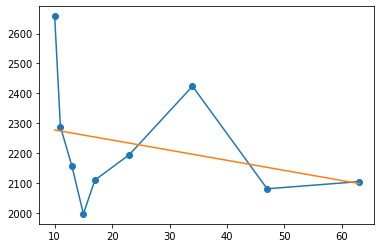

Patient          ID00216637202257988213445
Age                                     65
Sex                                   Male
SmokingStatus                 Never smoked
Name: 91, dtype: object
**********************************************


FVC vs Weeks Plot No. 92
------------------------


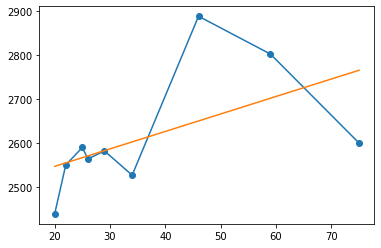

Patient          ID00218637202258156844710
Age                                     81
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 92, dtype: object
**********************************************


FVC vs Weeks Plot No. 93
------------------------


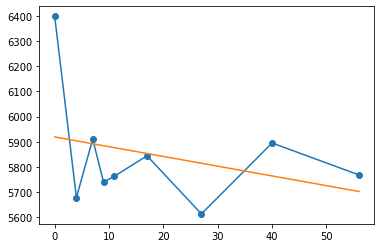

Patient          ID00219637202258203123958
Age                                     71
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 93, dtype: object
**********************************************


FVC vs Weeks Plot No. 94
------------------------


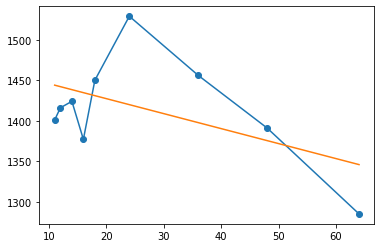

Patient          ID00221637202258717315571
Age                                     76
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 94, dtype: object
**********************************************


FVC vs Weeks Plot No. 95
------------------------


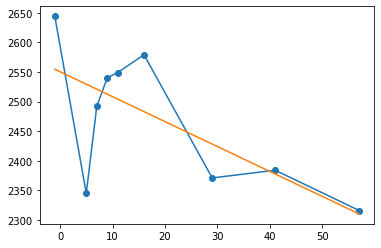

Patient          ID00222637202259066229764
Age                                     70
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 95, dtype: object
**********************************************


FVC vs Weeks Plot No. 96
------------------------


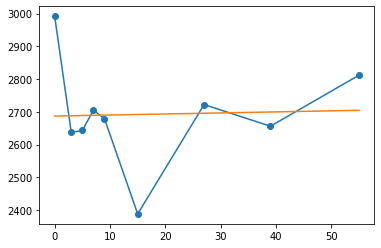

Patient          ID00224637202259281193413
Age                                     72
Sex                                   Male
SmokingStatus                 Never smoked
Name: 96, dtype: object
**********************************************


FVC vs Weeks Plot No. 97
------------------------


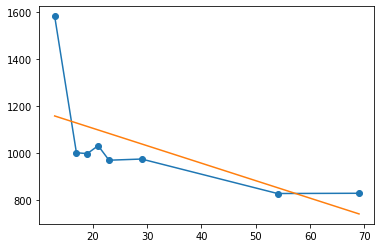

Patient          ID00225637202259339837603
Age                                     77
Sex                                 Female
SmokingStatus                 Never smoked
Name: 97, dtype: object
**********************************************


FVC vs Weeks Plot No. 98
------------------------


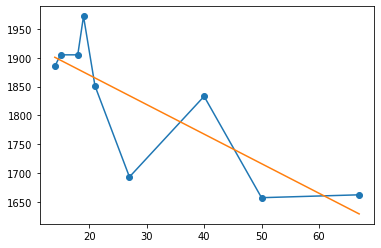

Patient          ID00228637202259965313869
Age                                     58
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 98, dtype: object
**********************************************


FVC vs Weeks Plot No. 99
------------------------


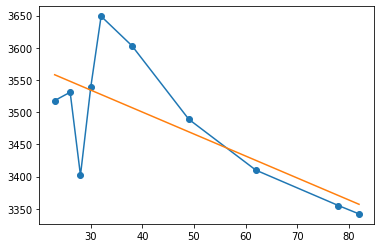

Patient          ID00229637202260254240583
Age                                     71
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 99, dtype: object
**********************************************


FVC vs Weeks Plot No. 100
------------------------


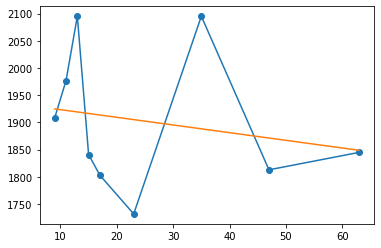

Patient          ID00232637202260377586117
Age                                     74
Sex                                 Female
SmokingStatus                 Never smoked
Name: 100, dtype: object
**********************************************


FVC vs Weeks Plot No. 101
------------------------


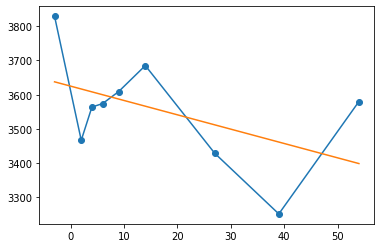

Patient          ID00233637202260580149633
Age                                     68
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 101, dtype: object
**********************************************


FVC vs Weeks Plot No. 102
------------------------


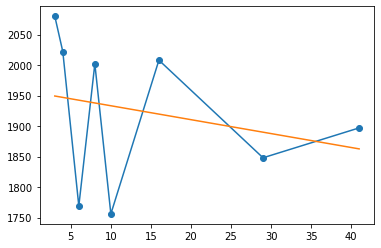

Patient          ID00234637202261078001846
Age                                     66
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 102, dtype: object
**********************************************


FVC vs Weeks Plot No. 103
------------------------


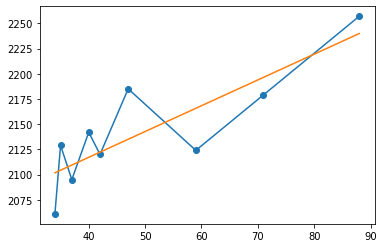

Patient          ID00235637202261451839085
Age                                     67
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 103, dtype: object
**********************************************


FVC vs Weeks Plot No. 104
------------------------


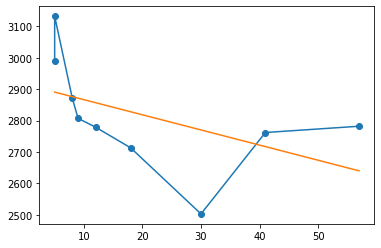

Patient          ID00240637202264138860065
Age                                     63
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 104, dtype: object
**********************************************


FVC vs Weeks Plot No. 105
------------------------


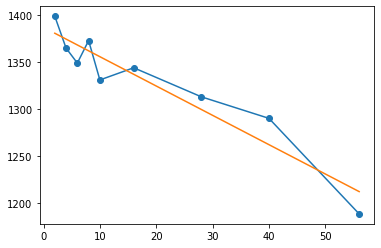

Patient          ID00241637202264294508775
Age                                     66
Sex                                 Female
SmokingStatus                 Never smoked
Name: 105, dtype: object
**********************************************


FVC vs Weeks Plot No. 106
------------------------


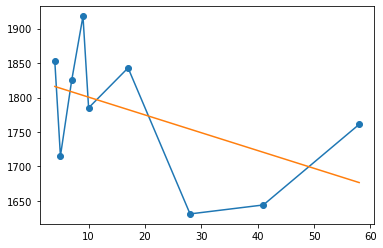

Patient          ID00242637202264759739921
Age                                     64
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 106, dtype: object
**********************************************


FVC vs Weeks Plot No. 107
------------------------


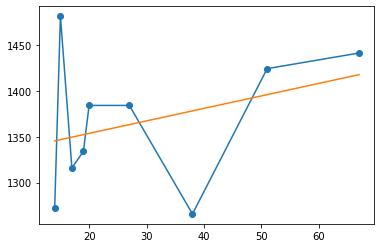

Patient          ID00248637202266698862378
Age                                     71
Sex                                 Female
SmokingStatus                 Never smoked
Name: 107, dtype: object
**********************************************


FVC vs Weeks Plot No. 108
------------------------


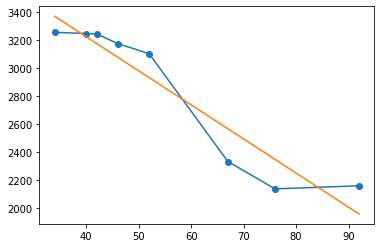

Patient          ID00249637202266730854017
Age                                     56
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 108, dtype: object
**********************************************


FVC vs Weeks Plot No. 109
------------------------


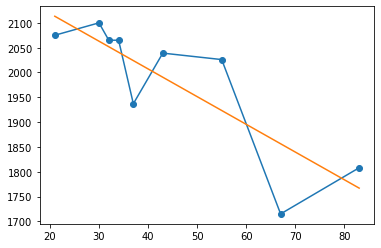

Patient          ID00251637202267455595113
Age                                     88
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 109, dtype: object
**********************************************


FVC vs Weeks Plot No. 110
------------------------


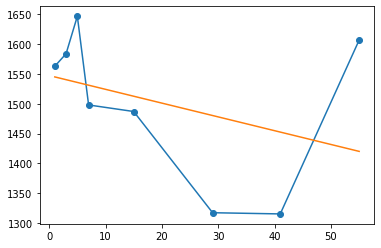

Patient          ID00255637202267923028520
Age                                     62
Sex                                 Female
SmokingStatus                 Never smoked
Name: 110, dtype: object
**********************************************


FVC vs Weeks Plot No. 111
------------------------


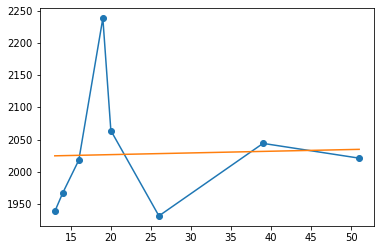

Patient          ID00264637202270643353440
Age                                     76
Sex                                 Female
SmokingStatus                 Never smoked
Name: 111, dtype: object
**********************************************


FVC vs Weeks Plot No. 112
------------------------


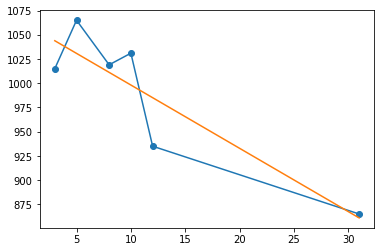

Patient          ID00267637202270790561585
Age                                     70
Sex                                 Female
SmokingStatus                 Never smoked
Name: 112, dtype: object
**********************************************


FVC vs Weeks Plot No. 113
------------------------


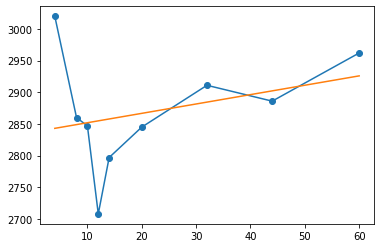

Patient          ID00273637202271319294586
Age                                     60
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 113, dtype: object
**********************************************


FVC vs Weeks Plot No. 114
------------------------


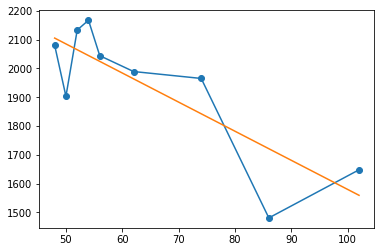

Patient          ID00275637202271440119890
Age                                     62
Sex                                 Female
SmokingStatus                 Never smoked
Name: 114, dtype: object
**********************************************


FVC vs Weeks Plot No. 115
------------------------


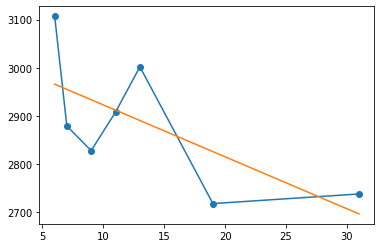

Patient          ID00276637202271694539978
Age                                     77
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 115, dtype: object
**********************************************


FVC vs Weeks Plot No. 116
------------------------


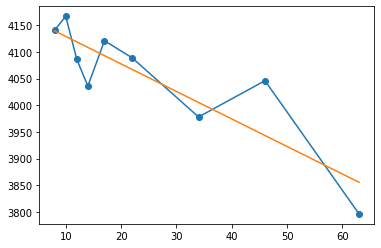

Patient          ID00279637202272164826258
Age                                     70
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 116, dtype: object
**********************************************


FVC vs Weeks Plot No. 117
------------------------


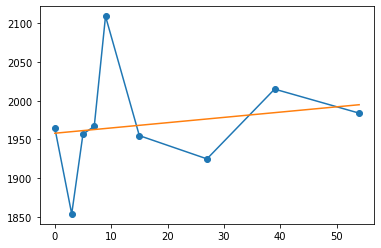

Patient          ID00283637202278714365037
Age                                     60
Sex                                   Male
SmokingStatus                 Never smoked
Name: 117, dtype: object
**********************************************


FVC vs Weeks Plot No. 118
------------------------


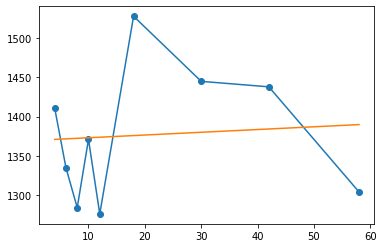

Patient          ID00285637202278913507108
Age                                     61
Sex                                 Female
SmokingStatus                 Never smoked
Name: 118, dtype: object
**********************************************


FVC vs Weeks Plot No. 119
------------------------


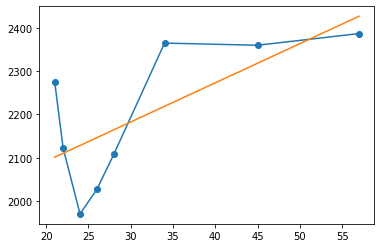

Patient          ID00288637202279148973731
Age                                     63
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 119, dtype: object
**********************************************


FVC vs Weeks Plot No. 120
------------------------


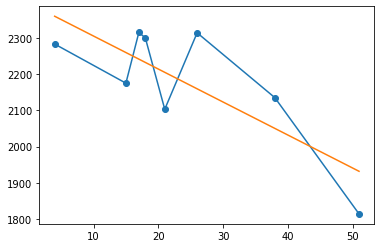

Patient          ID00290637202279304677843
Age                                     75
Sex                                   Male
SmokingStatus                 Never smoked
Name: 120, dtype: object
**********************************************


FVC vs Weeks Plot No. 121
------------------------


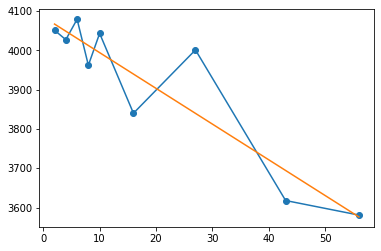

Patient          ID00291637202279398396106
Age                                     72
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 121, dtype: object
**********************************************


FVC vs Weeks Plot No. 122
------------------------


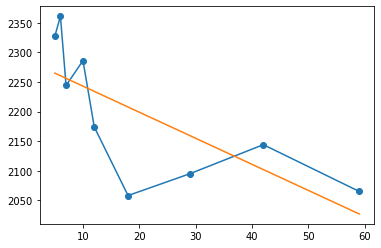

Patient          ID00294637202279614924243
Age                                     74
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 122, dtype: object
**********************************************


FVC vs Weeks Plot No. 123
------------------------


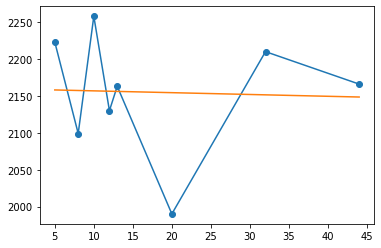

Patient          ID00296637202279895784347
Age                                     58
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 123, dtype: object
**********************************************


FVC vs Weeks Plot No. 124
------------------------


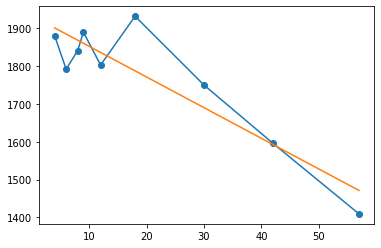

Patient          ID00298637202280361773446
Age                                     67
Sex                                 Female
SmokingStatus                 Never smoked
Name: 124, dtype: object
**********************************************


FVC vs Weeks Plot No. 125
------------------------


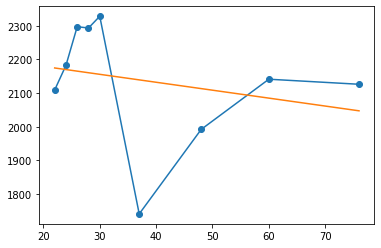

Patient          ID00299637202280383305867
Age                                     78
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 125, dtype: object
**********************************************


FVC vs Weeks Plot No. 126
------------------------


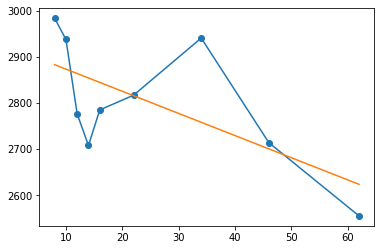

Patient          ID00305637202281772703145
Age                                     62
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 126, dtype: object
**********************************************


FVC vs Weeks Plot No. 127
------------------------


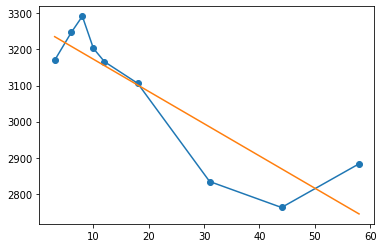

Patient          ID00307637202282126172865
Age                                     65
Sex                                   Male
SmokingStatus                 Never smoked
Name: 127, dtype: object
**********************************************


FVC vs Weeks Plot No. 128
------------------------


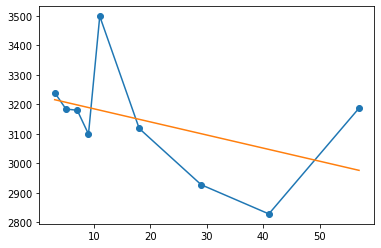

Patient          ID00309637202282195513787
Age                                     73
Sex                                   Male
SmokingStatus                 Never smoked
Name: 128, dtype: object
**********************************************


FVC vs Weeks Plot No. 129
------------------------


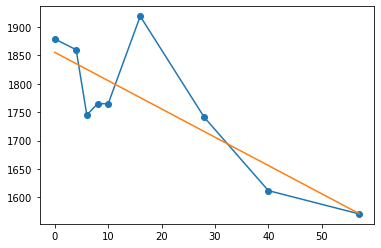

Patient          ID00312637202282607344793
Age                                     72
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 129, dtype: object
**********************************************


FVC vs Weeks Plot No. 130
------------------------


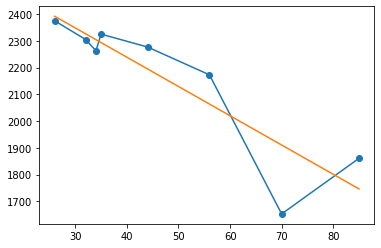

Patient          ID00317637202283194142136
Age                                     64
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 130, dtype: object
**********************************************


FVC vs Weeks Plot No. 131
------------------------


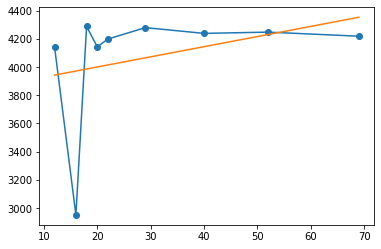

Patient          ID00319637202283897208687
Age                                     72
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 131, dtype: object
**********************************************


FVC vs Weeks Plot No. 132
------------------------


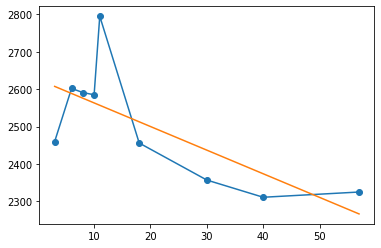

Patient          ID00322637202284842245491
Age                                     59
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 132, dtype: object
**********************************************


FVC vs Weeks Plot No. 133
------------------------


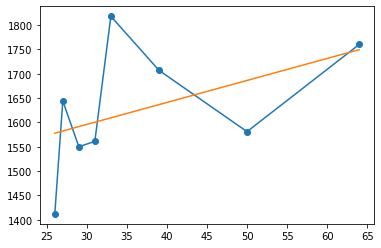

Patient          ID00323637202285211956970
Age                                     77
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 133, dtype: object
**********************************************


FVC vs Weeks Plot No. 134
------------------------


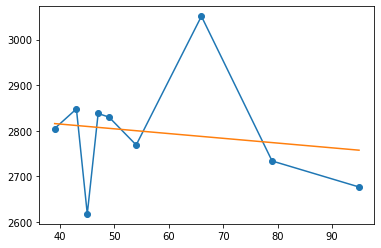

Patient          ID00329637202285906759848
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 134, dtype: object
**********************************************


FVC vs Weeks Plot No. 135
------------------------


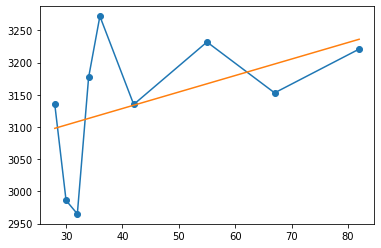

Patient          ID00331637202286306023714
Age                                     69
Sex                                   Male
SmokingStatus             Currently smokes
Name: 135, dtype: object
**********************************************


FVC vs Weeks Plot No. 136
------------------------


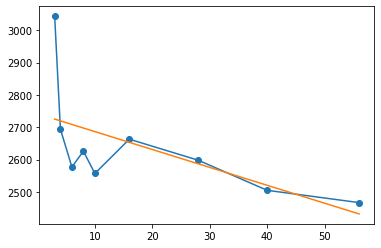

Patient          ID00335637202286784464927
Age                                     74
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 136, dtype: object
**********************************************


FVC vs Weeks Plot No. 137
------------------------


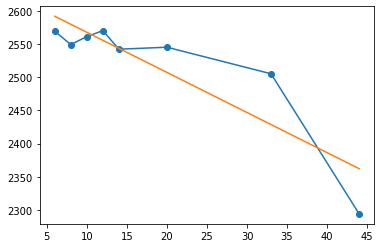

Patient          ID00336637202286801879145
Age                                     56
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 137, dtype: object
**********************************************


FVC vs Weeks Plot No. 138
------------------------


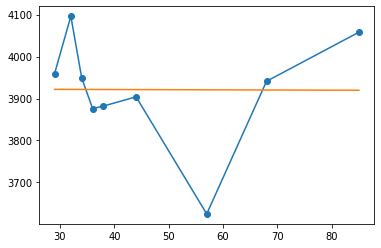

Patient          ID00337637202286839091062
Age                                     69
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 138, dtype: object
**********************************************


FVC vs Weeks Plot No. 139
------------------------


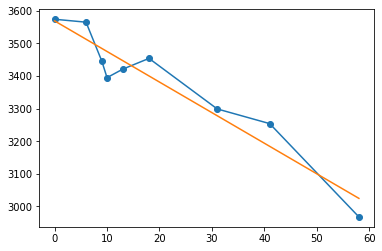

Patient          ID00339637202287377736231
Age                                     64
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 139, dtype: object
**********************************************


FVC vs Weeks Plot No. 140
------------------------


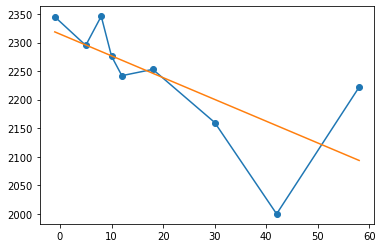

Patient          ID00340637202287399835821
Age                                     68
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 140, dtype: object
**********************************************


FVC vs Weeks Plot No. 141
------------------------


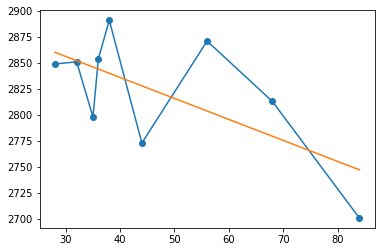

Patient          ID00341637202287410878488
Age                                     68
Sex                                 Female
SmokingStatus             Currently smokes
Name: 141, dtype: object
**********************************************


FVC vs Weeks Plot No. 142
------------------------


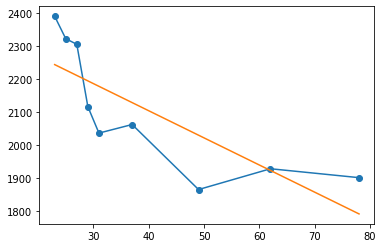

Patient          ID00342637202287526592911
Age                                     72
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 142, dtype: object
**********************************************


FVC vs Weeks Plot No. 143
------------------------


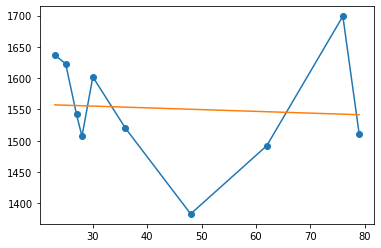

Patient          ID00343637202287577133798
Age                                     68
Sex                                 Female
SmokingStatus                 Never smoked
Name: 143, dtype: object
**********************************************


FVC vs Weeks Plot No. 144
------------------------


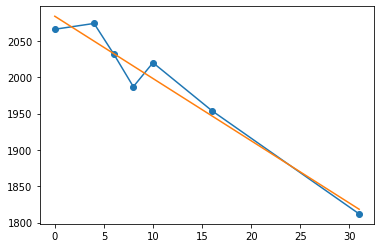

Patient          ID00344637202287684217717
Age                                     58
Sex                                   Male
SmokingStatus                 Never smoked
Name: 144, dtype: object
**********************************************


FVC vs Weeks Plot No. 145
------------------------


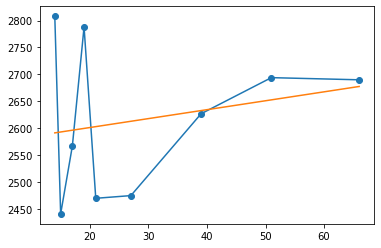

Patient          ID00351637202289476567312
Age                                     78
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 145, dtype: object
**********************************************


FVC vs Weeks Plot No. 146
------------------------


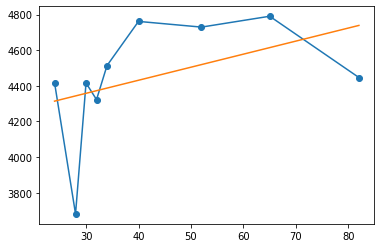

Patient          ID00355637202295106567614
Age                                     65
Sex                                   Male
SmokingStatus             Currently smokes
Name: 146, dtype: object
**********************************************


FVC vs Weeks Plot No. 147
------------------------


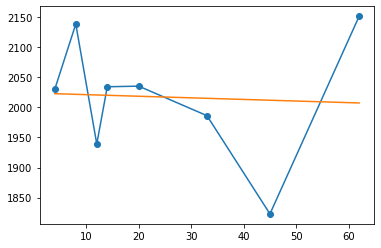

Patient          ID00358637202295388077032
Age                                     65
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 147, dtype: object
**********************************************


FVC vs Weeks Plot No. 148
------------------------


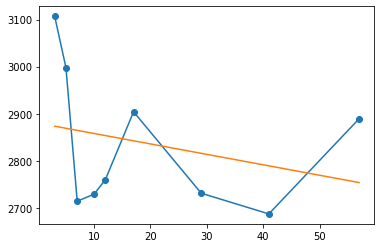

Patient          ID00360637202295712204040
Age                                     79
Sex                                   Male
SmokingStatus                 Never smoked
Name: 148, dtype: object
**********************************************


FVC vs Weeks Plot No. 149
------------------------


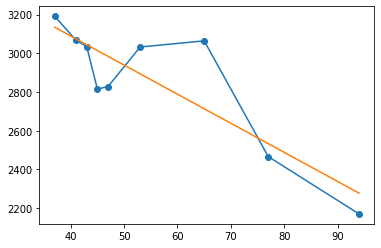

Patient          ID00364637202296074419422
Age                                     64
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 149, dtype: object
**********************************************


FVC vs Weeks Plot No. 150
------------------------


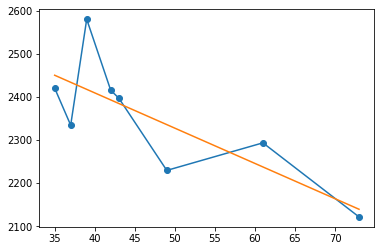

Patient          ID00365637202296085035729
Age                                     71
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 150, dtype: object
**********************************************


FVC vs Weeks Plot No. 151
------------------------


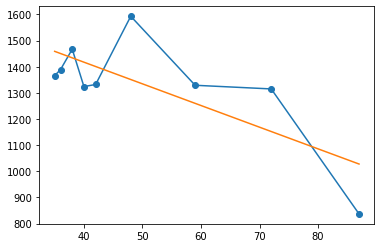

Patient          ID00367637202296290303449
Age                                     57
Sex                                 Female
SmokingStatus                 Never smoked
Name: 151, dtype: object
**********************************************


FVC vs Weeks Plot No. 152
------------------------


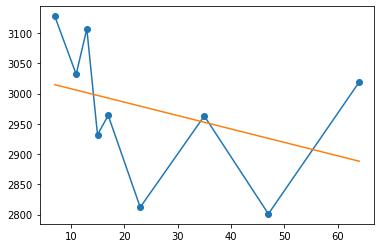

Patient          ID00368637202296470751086
Age                                     65
Sex                                   Male
SmokingStatus                 Never smoked
Name: 152, dtype: object
**********************************************


FVC vs Weeks Plot No. 153
------------------------


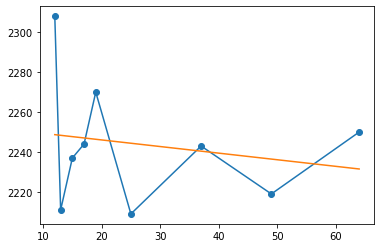

Patient          ID00370637202296737666151
Age                                     75
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 153, dtype: object
**********************************************


FVC vs Weeks Plot No. 154
------------------------


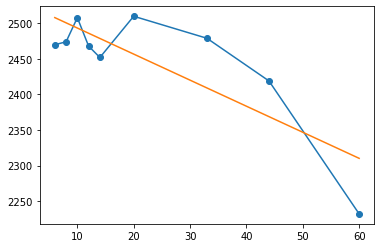

Patient          ID00371637202296828615743
Age                                     71
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 154, dtype: object
**********************************************


FVC vs Weeks Plot No. 155
------------------------


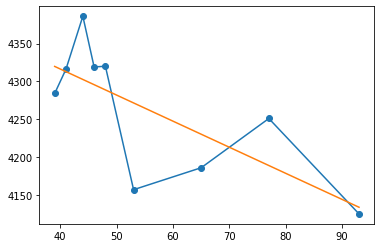

Patient          ID00376637202297677828573
Age                                     72
Sex                                   Male
SmokingStatus                 Never smoked
Name: 155, dtype: object
**********************************************


FVC vs Weeks Plot No. 156
------------------------


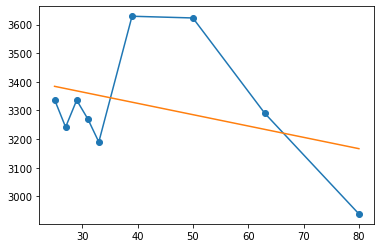

Patient          ID00378637202298597306391
Age                                     56
Sex                                   Male
SmokingStatus                 Never smoked
Name: 156, dtype: object
**********************************************


FVC vs Weeks Plot No. 157
------------------------


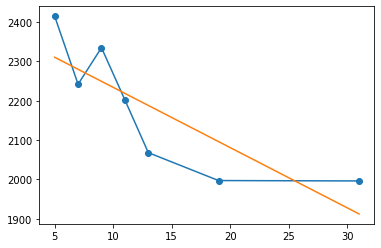

Patient          ID00381637202299644114027
Age                                     62
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 157, dtype: object
**********************************************


FVC vs Weeks Plot No. 158
------------------------


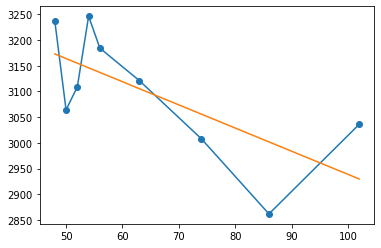

Patient          ID00383637202300493233675
Age                                     64
Sex                                 Female
SmokingStatus                 Never smoked
Name: 158, dtype: object
**********************************************


FVC vs Weeks Plot No. 159
------------------------


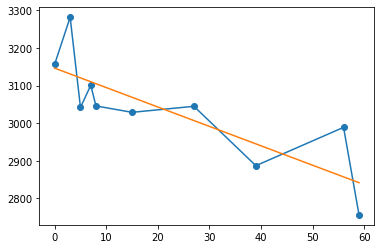

Patient          ID00388637202301028491611
Age                                     53
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 159, dtype: object
**********************************************


FVC vs Weeks Plot No. 160
------------------------


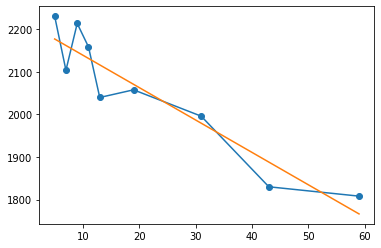

Patient          ID00392637202302319160044
Age                                     66
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 160, dtype: object
**********************************************


FVC vs Weeks Plot No. 161
------------------------


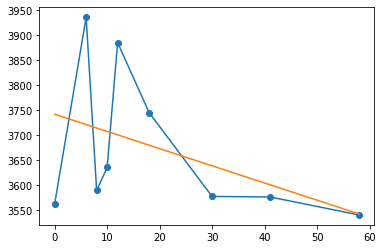

Patient          ID00393637202302431697467
Age                                     67
Sex                                   Male
SmokingStatus                 Never smoked
Name: 161, dtype: object
**********************************************


FVC vs Weeks Plot No. 162
------------------------


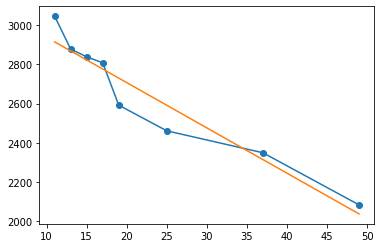

Patient          ID00398637202303897337979
Age                                     70
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 162, dtype: object
**********************************************


FVC vs Weeks Plot No. 163
------------------------


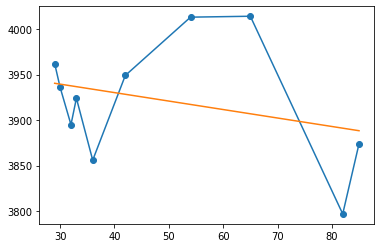

Patient          ID00400637202305055099402
Age                                     55
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 163, dtype: object
**********************************************


FVC vs Weeks Plot No. 164
------------------------


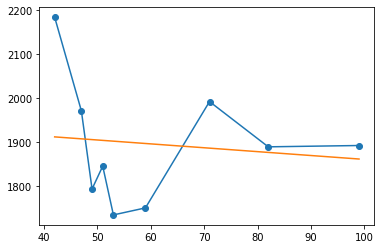

Patient          ID00401637202305320178010
Age                                     74
Sex                                 Female
SmokingStatus                    Ex-smoker
Name: 164, dtype: object
**********************************************


FVC vs Weeks Plot No. 165
------------------------


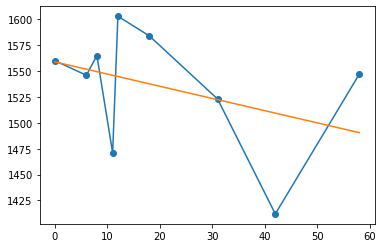

Patient          ID00405637202308359492977
Age                                     61
Sex                                 Female
SmokingStatus                 Never smoked
Name: 165, dtype: object
**********************************************


FVC vs Weeks Plot No. 166
------------------------


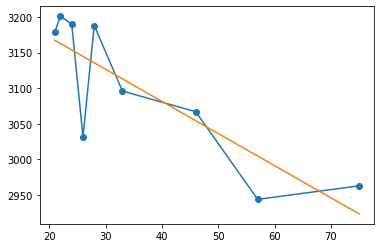

Patient          ID00407637202308788732304
Age                                     66
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 166, dtype: object
**********************************************


FVC vs Weeks Plot No. 167
------------------------


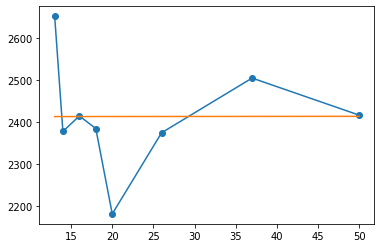

Patient          ID00408637202308839708961
Age                                     74
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 167, dtype: object
**********************************************


FVC vs Weeks Plot No. 168
------------------------


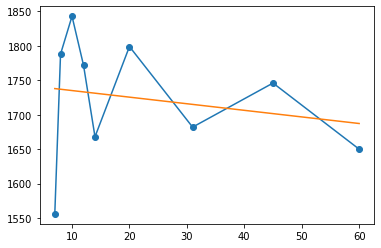

Patient          ID00411637202309374271828
Age                                     65
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 168, dtype: object
**********************************************


FVC vs Weeks Plot No. 169
------------------------


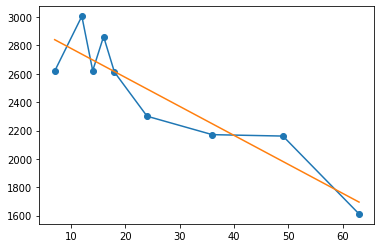

Patient          ID00414637202310318891556
Age                                     65
Sex                                   Male
SmokingStatus                 Never smoked
Name: 169, dtype: object
**********************************************


FVC vs Weeks Plot No. 170
------------------------


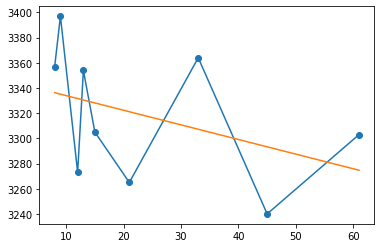

Patient          ID00417637202310901214011
Age                                     66
Sex                                   Male
SmokingStatus                 Never smoked
Name: 170, dtype: object
**********************************************


FVC vs Weeks Plot No. 171
------------------------


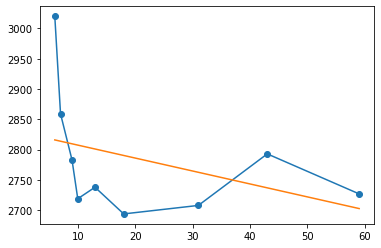

Patient          ID00419637202311204720264
Age                                     73
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 171, dtype: object
**********************************************


FVC vs Weeks Plot No. 172
------------------------


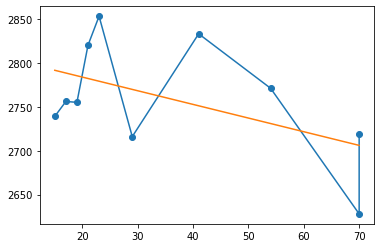

Patient          ID00421637202311550012437
Age                                     68
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 172, dtype: object
**********************************************


FVC vs Weeks Plot No. 173
------------------------


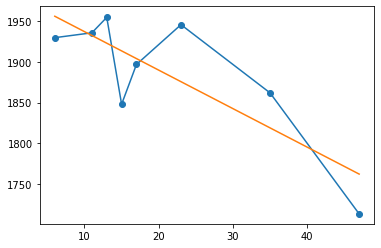

Patient          ID00422637202311677017371
Age                                     73
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 173, dtype: object
**********************************************


FVC vs Weeks Plot No. 174
------------------------


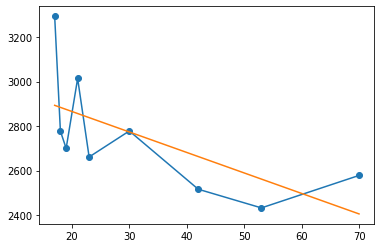

Patient          ID00423637202312137826377
Age                                     72
Sex                                   Male
SmokingStatus                    Ex-smoker
Name: 174, dtype: object
**********************************************


FVC vs Weeks Plot No. 175
------------------------


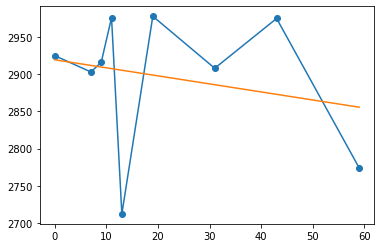

Patient          ID00426637202313170790466
Age                                     73
Sex                                   Male
SmokingStatus                 Never smoked
Name: 175, dtype: object
**********************************************




In [ ]:
for i in range(176): 
    print("FVC vs Weeks Plot No.",i)
    print("------------------------")
    plot_patient_id(i)
    print("**********************************************\n\n")

From the above graph except very few most of the ex-smoker have a decreasing trend in FVC values as comparative weeks increase from baseline. But most of the never smoked and currently smoked people have a slight increasing trend in FCV values as increase in comparative weeks.

### Age

In [ ]:
df_train_uni['Age'].describe()

count    176.000000
mean      67.261364
std        7.088009
min       49.000000
25%       63.000000
50%       68.000000
75%       72.000000
max       88.000000
Name: Age, dtype: float64

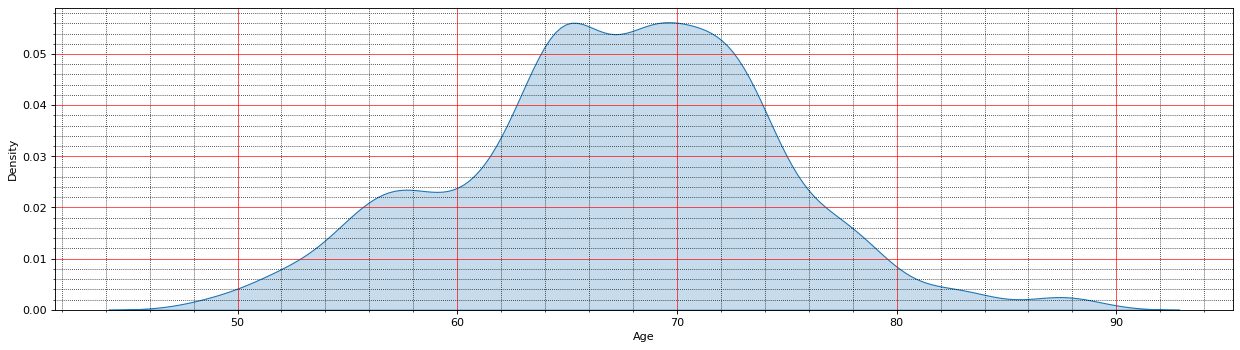

In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.density.html
# http://jonathansoma.com/lede/data-studio/matplotlib/adding-grid-lines-to-a-matplotlib-chart/

figure(figsize=(19,5), dpi=80)
ax = sns.kdeplot(df_pul_fib_train['Age'], shade = True)
# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()
# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.6', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.7', color='black')

The age starts from minimum 49 to maximum 88 years, high density of age is observed around 70 years.

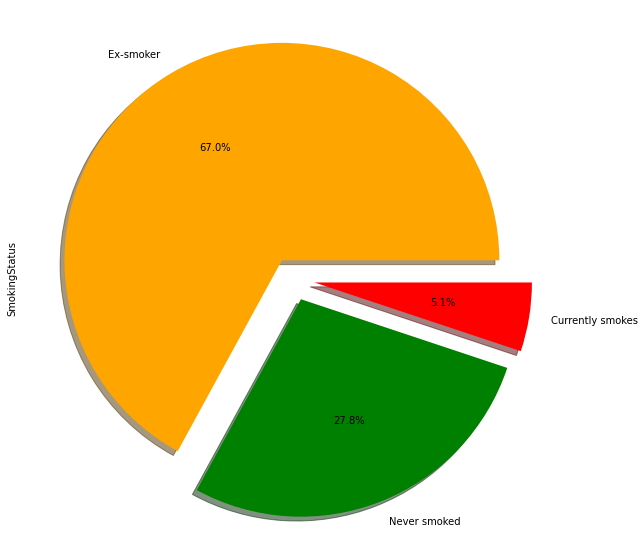

In [ ]:
# https://stackoverflow.com/a/57967795

figure(figsize=(10,10))
a = df_train_uni['SmokingStatus'].value_counts()
myexplode = [0.1, 0.1, 0.1]
a.plot(kind = 'pie', colors = ['orange', 'green', 'red'], shadow = True, autopct='%1.1f%%', explode = myexplode)

Above chart shows smoking status of individuals, maximum chunk is taken by ex-smokers i.e. 67%. 

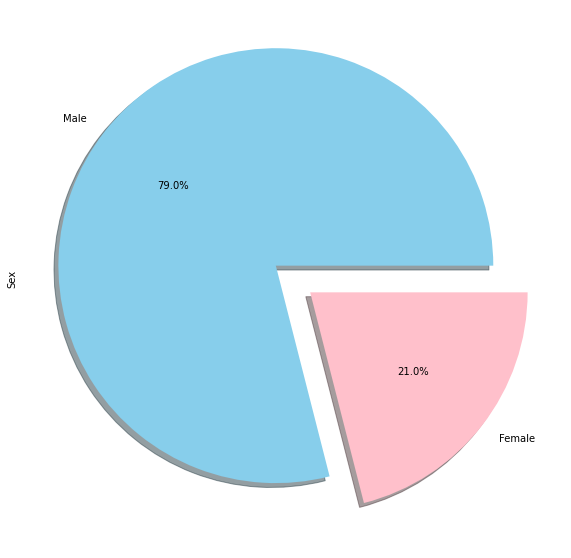

In [ ]:
# https://stackoverflow.com/a/57967795

figure(figsize=(10,10))
a = df_train_uni['Sex'].value_counts()
myexplode = [0.1, 0.1]
a.plot(kind = 'pie', colors = ['skyblue', 'pink'], shadow = True, autopct='%1.1f%%', explode = myexplode)

From this data set maximum reading is taken from males (79%)

### Forced vital capacity of train

In [ ]:
df_pul_fib_train['FVC'].describe()

count    1549.000000
mean     2690.479019
std       832.770959
min       827.000000
25%      2109.000000
50%      2641.000000
75%      3171.000000
max      6399.000000
Name: FVC, dtype: float64

In [ ]:
df_pul_fib_train['FVC'].describe()

count    1549.000000
mean     2690.479019
std       832.770959
min       827.000000
25%      2109.000000
50%      2641.000000
75%      3171.000000
max      6399.000000
Name: FVC, dtype: float64

The maximim, minimum, Standard Deviation and mean of FVC in train is found to be 6399, 827, 832 and 2690 ml respectively. Below shows the PDF.

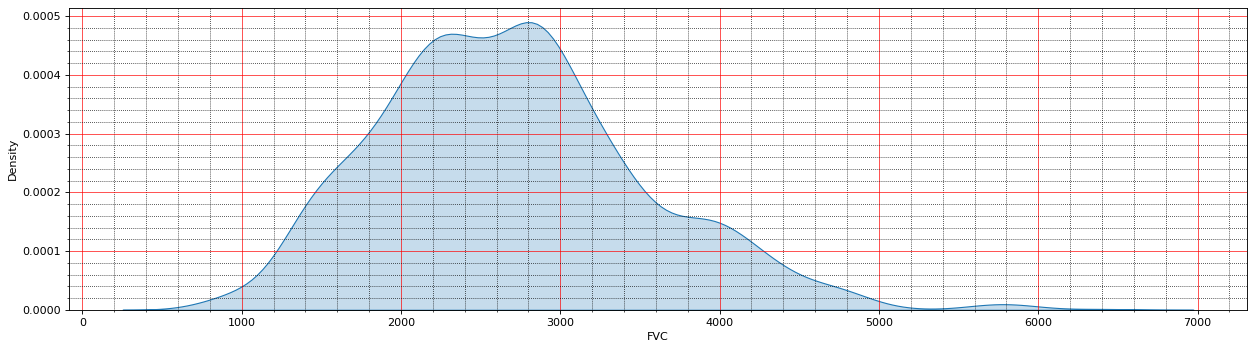

In [ ]:
# http://jonathansoma.com/lede/data-studio/matplotlib/adding-grid-lines-to-a-matplotlib-chart/
figure(figsize=(19,5), dpi=80)
ax = sns.kdeplot(df_pul_fib_train['FVC'], shade = True)
# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()
# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.6', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.7', color='black')

Above PDF shows the probability of forced vital capacity is around 2250 ml (first maximum probability) and second maximum probability is around 2700 ml.

### Weeks

In [ ]:
df_pul_fib_train['Weeks'].describe()

count    1549.000000
mean       31.861846
std        23.247550
min        -5.000000
25%        12.000000
50%        28.000000
75%        47.000000
max       133.000000
Name: Weeks, dtype: float64

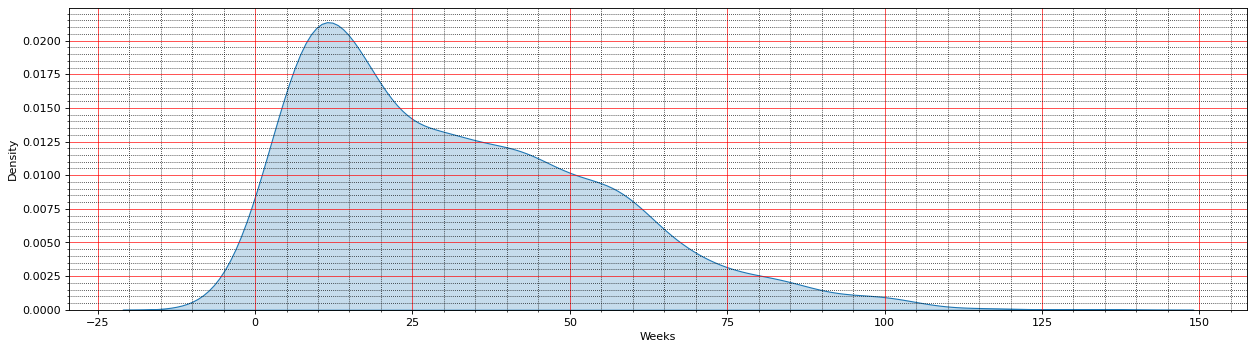

In [ ]:
# http://jonathansoma.com/lede/data-studio/matplotlib/adding-grid-lines-to-a-matplotlib-chart/

figure(figsize=(19,5), dpi=80)
ax = sns.kdeplot(df_pul_fib_train['Weeks'], shade = True)
# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()
# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.6', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.7', color='black')

Most of the patients will do CT scan on 0th (Baseline of scan) week to 60th week,  maximum probability of CT scan is around 12th week.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


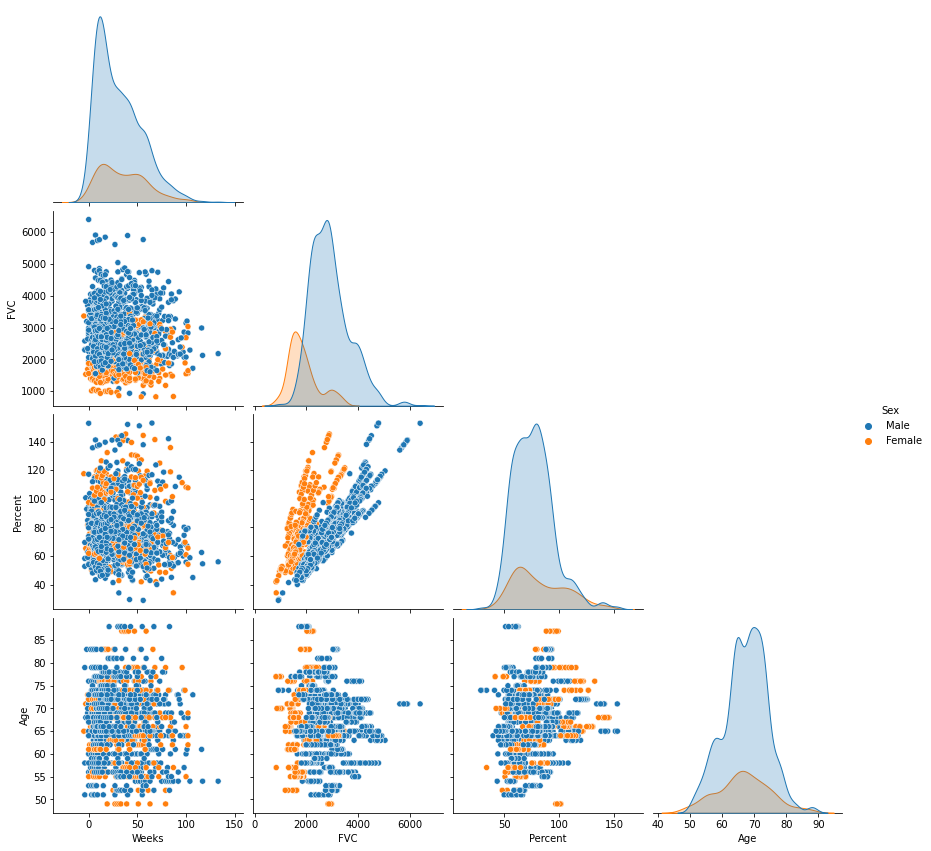

In [ ]:
sns.pairplot(df_pul_fib_train, hue ='Sex',diag_kind = 'kde', size = 3, corner=True)
map_lower(sns.kdeplot, levels=4, color=".2")
plt.show()

The above graph shows the bivariate distributions of male and female against weeks, FVC, percentage, and age.Here male value is more than female value as males are more in number.

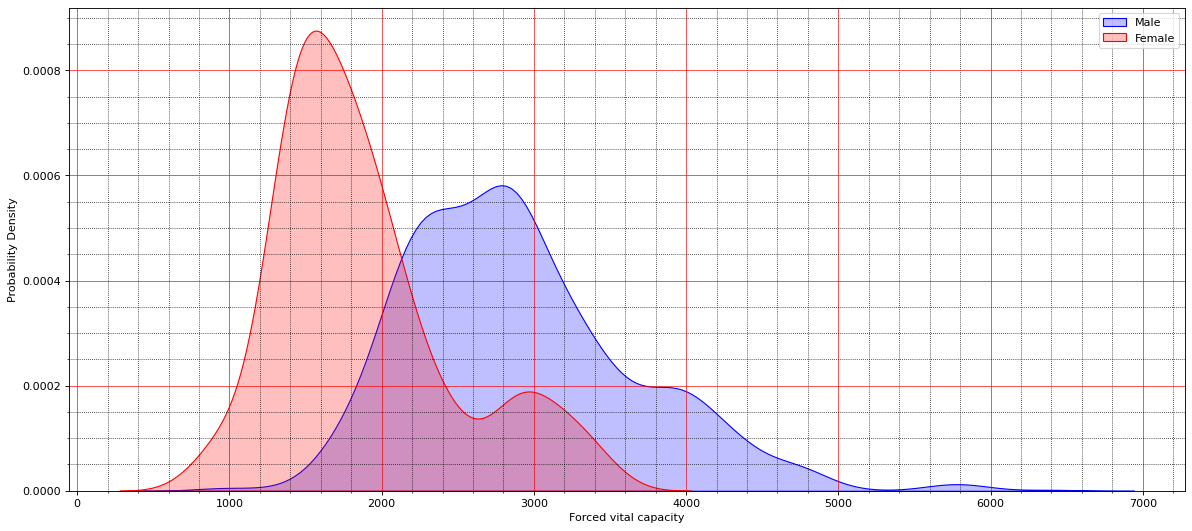

In [ ]:
# https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/
figure(figsize=(18,8), dpi=80)
ax = sns.kdeplot(df_pul_fib_train.loc[(df_pul_fib_train['Sex']=='Male'),'FVC'], color='b', shade=True, Label='Male') 
ax = sns.kdeplot(df_pul_fib_train.loc[(df_pul_fib_train['Sex']=='Female'),'FVC'], color='r', shade=True, Label='Female') 
ax.legend()
# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()
# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.6', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.7', color='black')
plt.xlabel('Forced vital capacity') 
plt.ylabel('Probability Density') 
plt.legend() 
plt.show()

The above graph shows that the female have the more probability of having 1060 ml of FVC.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


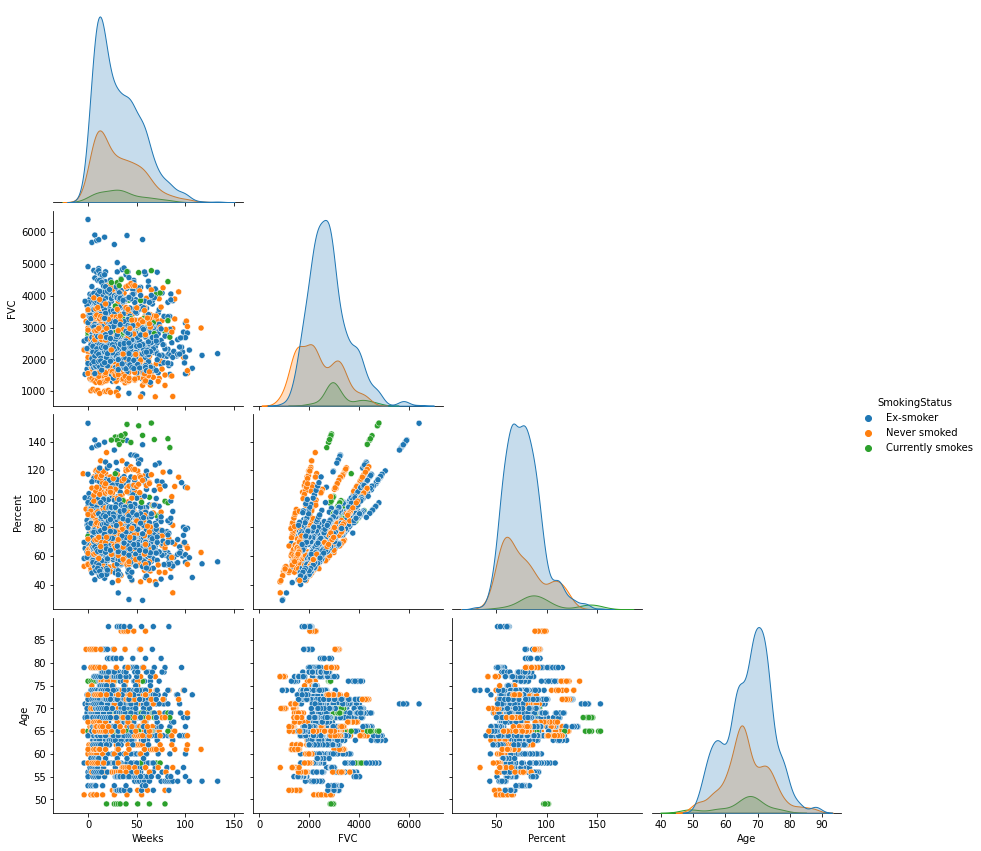

In [ ]:
sns.pairplot(df_pul_fib_train, hue ='SmokingStatus',diag_kind = 'kde', size = 3, corner=True)
plt.show()

The above graph shows the bivariate distributions of smoking status (ex-smoker, never smoked, and currently smoker) against weeks, FVC, percentage, and age. According to the observations, we are going to investigate deep into smoking status.

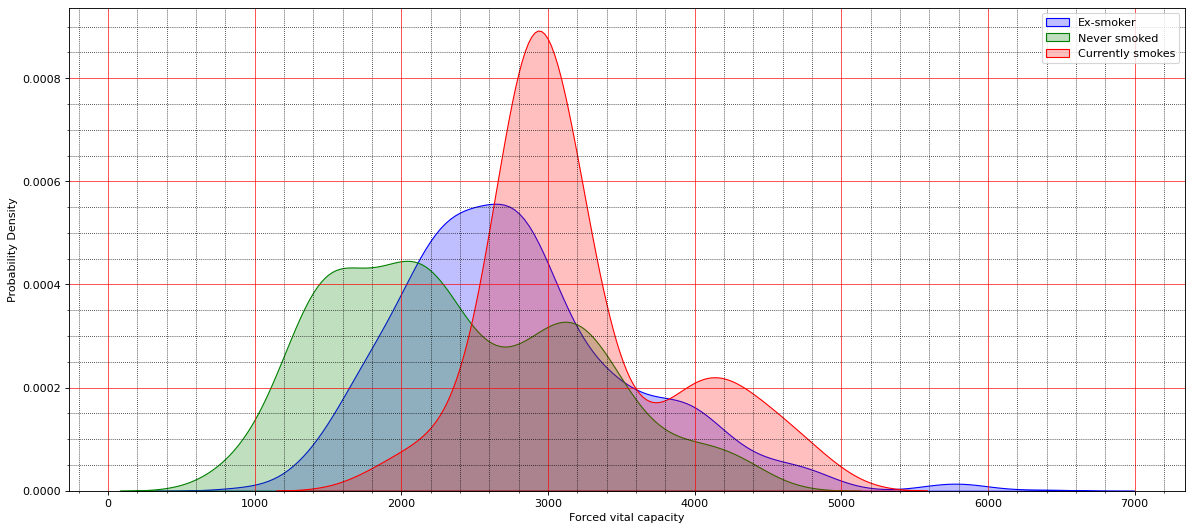

In [ ]:
# https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/
figure(figsize=(18,8), dpi=80)
ax = sns.kdeplot(df_pul_fib_train.loc[(df_pul_fib_train['SmokingStatus']=='Ex-smoker'),'FVC'], color='b', shade=True, Label='Ex-smoker') 
ax = sns.kdeplot(df_pul_fib_train.loc[(df_pul_fib_train['SmokingStatus']=='Never smoked'),'FVC'], color='g', shade=True, Label='Never smoked') 
ax = sns.kdeplot(df_pul_fib_train.loc[(df_pul_fib_train['SmokingStatus']=='Currently smokes'),'FVC'], color='r', shade=True, Label='Currently smokes') 
ax.legend()
# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()
# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.6', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.7', color='black')
plt.xlabel('Forced vital capacity') 
plt.ylabel('Probability Density') 
plt.legend(["Ex-smoker", "Never smoked", "Currently smokes"]) 
plt.show()

Surprisingly the above PDF graph indicates that currently smoking people have more probability of FVC around 3000 ml.

## Now compute pairwise correlation 

In [ ]:
df_pul_fib_train_corr = df_pul_fib_train.corr()
df_pul_fib_train_corr

Weeks       FVC   Percent       Age
Weeks    1.000000 -0.041447 -0.012536 -0.059473
FVC     -0.041447  1.000000  0.671964 -0.094125
Percent -0.012536  0.671964  1.000000  0.095949
Age     -0.059473 -0.094125  0.095949  1.000000

In [ ]:
# https://stackoverflow.com/q/52064266
df_pul_fib_train_corr.style.background_gradient(cmap='coolwarm')

<Figure size 1440x640 with 0 Axes>

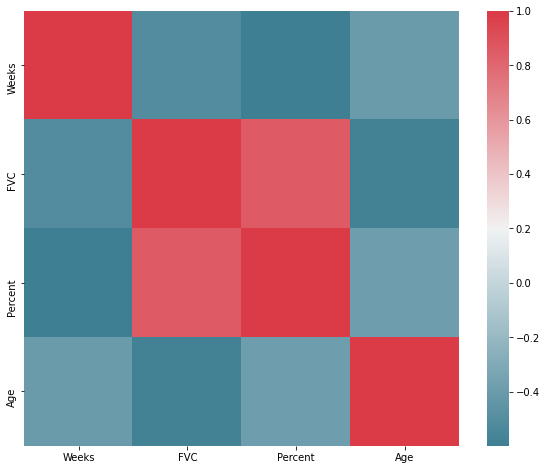

In [ ]:
# https://stackoverflow.com/a/42977946

f, ax = plt.subplots(figsize=(10, 8))
corr = df_pul_fib_train_corr.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)

Pairwise correlation computation shows that there is a strong relation between FVC and Percent because it is computed from typical FVC of a similar characteristics. Another significant correlation is between FVC and Age.